In [758]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy import interpolate
from scipy.special import expit
from scipy.interpolate import griddata
from scipy.stats import beta
from mpl_toolkits.mplot3d import Axes3D




In [759]:
#Function: sampling from GP process: Gaussian Process sampler using griddata
def sample_gp(param, X, U, seed):
    np.random.seed(seed)
    XX, UU = np.meshgrid(X, U)
    XU_flat = np.c_[XX.ravel(), UU.ravel()]
    mean = np.zeros(len(XU_flat))
    distances = np.linalg.norm((XU_flat[:, None] - XU_flat[None, :]) / param['ls'], axis=2)
    K = param['alpha'][0] * np.exp(-0.5 * distances**2)
    f_sample = np.random.multivariate_normal(mean, K)
    
    return lambda x, u: griddata(XU_flat, f_sample, (x, u), method='linear')



In [760]:
# Function: generate the Raw Dataset that contains the Combined Dataset D
def generate_data(n_raw, n_rct, n_tar, n_obs, random_seed = 42):  

    # Coefficients for generating co-variates using beta distribution 
    alpha_x, beta_x = 8, 2  # Skewed towards higher values
    alpha_u, beta_u = 3, 4

    # Linear coefficients for selection and propensity scores
    #coef_S = [1]  # Coefficients for P(S=1|X)
    coef_S = [3]  # Coefficients for P(S=1|X)
    coef_A = [1, 100.5]  # Coefficients a, b, c for P(A=1|X, U)
    #coef_A = [0, -50]

    # Define coefficients for Y0 and Y1
    coef_y0 = [-0.5, -1.2, 0.8, -0.2, 2.3]  # Coefficients [a, b, c] for Y0
    coef_y1 = [1.2, 12.2, -0.5, -1.2, 4.8]  # Coefficients [a, b, c] for Y1

    # Define the parameters for the Gaussian Processes (GPs)
    #om_A0_par = {'ls': [1, 1], 'alpha': [1, 1]}
    #om_A1_par = {'ls': [0.5, 0.5], 'alpha': [5, 5]}
    #w_sel_par = {'ls': [1, 1e6], 'alpha': [10, 0]}
    #w_trt_par = {'ls': [1e6, 0.5], 'alpha': [0, 10]}

    # Generate GP models for outcome and probabilities
    #om_A0 = sample_gp(om_A0_par, X_range, U_range, seed=0)  # Outcome model A=0
    #om_A1 = sample_gp(om_A1_par, X_range, U_range, seed=1)  # Outcome model A=1
    #w_sel = sample_gp(w_sel_par, X_range, U_range, seed=2)  # Selection score P(S=1 | X, U)
    #w_trt = sample_gp(w_trt_par, X_range, U_range, seed=3)  # Propensity score P(A=1 | X, U)


    np.random.seed(random_seed)
    df_raw = pd.DataFrame(index=np.arange(n_raw))
    df_raw["X"] = beta.rvs(alpha_x, beta_x, size=n_raw) 
    df_raw["U"] = beta.rvs(alpha_u, beta_u, size=n_raw)
    df_raw["X"] = 2 * (df_raw["X"] - df_raw["X"].min()) / (df_raw["X"].max() - df_raw["X"].min()) - 1 # map to [-1,1]
    df_raw["U"] = 2 * (df_raw["U"] - df_raw["U"].min()) / (df_raw["U"].max() - df_raw["U"].min()) - 1 # map to [-1,1]




    # Selection probability (P(S=1|X))
    #df_raw["P(S=1|X)"] = np.clip(expit(w_sel(df_raw["X"], df_raw["U"])), 0.1, 0.9)
    #df_raw["S"] = (df_raw["P(S=1|X)"] > np.random.rand(n_raw)).astype(int)
    df_raw["P(S=1|X)"] = expit(coef_S[0] * df_raw["X"])
    df_raw["S"] = (df_raw["P(S=1|X)"] > np.random.rand(n_raw)).astype(int)



    # Assign the Y0 and Y1 values using outcome model under treatment A=0 and outcome model under treatment A=1
    #df_raw["Y0"] = om_A0(df_raw["X"], df_raw["U"])
    #df_raw["Y1"] = om_A1(df_raw["X"], df_raw["U"])
    df_raw["Y0"] = coef_y0[1] * df_raw["X"] + coef_y0[3] * df_raw["U"] + coef_y0[4]
    df_raw["Y1"] = coef_y1[1] * df_raw["X"] + coef_y1[3] * df_raw["U"] + coef_y1[4]
    #df_raw["Y0"] = coef_y0[0] * df_raw["X"]**2 + coef_y0[1] * df_raw["X"] + coef_y0[2] * df_raw["U"]**2 + coef_y0[3] * df_raw["U"] + coef_y0[4]
    #df_raw["Y1"] = coef_y1[0] * df_raw["X"]**2 + coef_y1[1] * df_raw["X"] + coef_y1[2] * df_raw["U"]**2 + coef_y1[3] * df_raw["U"] + coef_y1[4]

    # Randomly select trial (S=1) and target (S=0) participants within the Raw Dataset
    df_target = df_raw[df_raw["S"] == 0].sample(n=n_tar, random_state=random_seed)
    df_trial = df_raw[df_raw["S"] == 1].sample(n=n_rct, random_state=random_seed)

    # Adaptively select trial (S=1)
    n_adap1 = n_rct // 3
    n_adap2 = 2*(n_rct//3) + n_rct%3
    df_raw_s1 = df_raw[df_raw["S"] == 1]
    random_indices = df_raw_s1.sample(n=n_adap1, random_state=random_seed).index # Step 1: Initialize trial data with a small random subset
    random_trial = df_raw_s1.loc[random_indices].copy()
    remaining1 = df_raw_s1.drop(random_indices)
    remaining2 = remaining1.copy()
    remaining3 = remaining1.copy()
    df_trial_adap1 = random_trial.copy()
    df_trial_adap2 = random_trial.copy()
    df_trial_adap3 = random_trial.copy()
    model = RandomForestRegressor(n_estimators=50, random_state=random_seed) 

    # Generating adaptive trial sample 1 by 1
    for i in range(n_adap2):
        model.fit(df_trial_adap1[['X']].to_numpy(), df_trial_adap1['Y1'].to_numpy())
        variances = np.var([tree.predict(remaining1[['X']].to_numpy()) for tree in model.estimators_], axis=0)
        remaining1["variance"] = variances
        highest_variance_trial = remaining1.nlargest(1, "variance")
        df_trial_adap1 = pd.concat([df_trial_adap1, highest_variance_trial])
        remaining1 = remaining1.drop(highest_variance_trial.index)  # Remove the selected point
        remaining1.drop(columns=["variance"], inplace=True, errors="ignore")  # Clean up variance column

    # Generating adaptive trial in batch
    chunk_size = n_adap2 // 5
    total_added = 0
    while total_added < n_adap2:
        model.fit(df_trial_adap2[['X']].to_numpy(), df_trial_adap2['Y1'].to_numpy())
        variances = np.var([tree.predict(remaining2[['X']].to_numpy()) for tree in model.estimators_], axis=0)
        remaining2["variance"] = variances
        points_to_add = min(chunk_size, n_adap2 - total_added)
        top_variance_points = remaining2.nlargest(points_to_add, "variance")
        df_trial_adap2 = pd.concat([df_trial_adap2, top_variance_points])
        remaining2 = remaining2.drop(top_variance_points.index)  # Remove selected points
        remaining2.drop(columns=["variance"], inplace=True, errors="ignore")
        total_added += len(top_variance_points)

    # Generating adaptive trial all at once
    model.fit(df_trial_adap3[['X']].to_numpy(), df_trial_adap3['Y1'].to_numpy())
    variances = np.var([tree.predict(remaining3[['X']].to_numpy()) for tree in model.estimators_], axis=0)
    remaining3["variance"] = variances
    all_variance_points = remaining3.nlargest(n_adap2, "variance")
    df_trial_adap3 = pd.concat([df_trial_adap3, all_variance_points])
    remaining3.drop(columns=["variance"], inplace=True, errors="ignore")

    assert len(df_trial_adap1) == n_adap1 + n_adap2, "Mismatch in adaptive trial size for 1-by-1 approach."
    assert len(df_trial_adap2) == n_adap1 + n_adap2, "Mismatch in adaptive trial size for batch approach."
    assert len(df_trial_adap3) == n_adap1 + n_adap2, "Mismatch in adaptive trial size for all-at-once approach."





    # Assign Y and A values for the trial set, randomly assign to receive Drug or Not
    df_trial["A"] = (np.random.rand(len(df_trial)) > 0.5).astype(int)
    df_trial["Y"] = (df_trial["Y1"] * df_trial["A"] + df_trial["Y0"] * (1 - df_trial["A"]))

    # Assign Y and A values for the adaptive trial set, randomly assign to receive Drug or Not
    df_trial_adap1["A"] = (np.random.rand(len(df_trial_adap1)) > 0.5).astype(int)
    df_trial_adap1["Y"] = (df_trial_adap1["Y1"] * df_trial_adap1["A"] + df_trial_adap1["Y0"] * (1 - df_trial_adap1["A"]))

    df_trial_adap2["A"] = (np.random.rand(len(df_trial_adap2)) > 0.5).astype(int)
    df_trial_adap2["Y"] = (df_trial_adap2["Y1"] * df_trial_adap2["A"] + df_trial_adap2["Y0"] * (1 - df_trial_adap2["A"]))

    df_trial_adap3["A"] = (np.random.rand(len(df_trial_adap3)) > 0.5).astype(int)
    df_trial_adap3["Y"] = (df_trial_adap3["Y1"] * df_trial_adap3["A"] + df_trial_adap3["Y0"] * (1 - df_trial_adap3["A"]))

   

   


    # Generate Observational Dataset (D_obs)
    np.random.seed(random_seed + 1)
    df_obs = pd.DataFrame(index=np.arange(n_obs))
    #df_obs["X"] = 2 * np.random.rand(n_obs) - 1
    #df_obs["U"] = 2 * np.random.rand(n_obs) - 1
    df_obs["X"] = beta.rvs(alpha_x, beta_x, size=n_obs) 
    df_obs["U"] = beta.rvs(alpha_u, beta_u, size=n_obs)
    df_obs["X"] = 2 * (df_obs["X"] - df_obs["X"].min()) / (df_obs["X"].max() - df_obs["X"].min()) - 1 # map to [-1,1]
    df_obs["U"] = 2 * (df_obs["U"] - df_obs["U"].min()) / (df_obs["U"].max() - df_obs["U"].min()) - 1 # map to [-1,1]


    # Treatment assignment in D_obs based on biased mechanism
    #df_obs["P(A=1|X,U)"] = np.clip(expit(w_trt(df_obs["X"], df_obs["U"])), 0.1, 0.9) # Not random now
    #df_obs["A"] = (df_obs["P(A=1|X,U)"] > np.random.rand(n_obs)).astype(int)
    df_obs["P(A=1|X,U)"] = expit(coef_A[0] * df_obs["X"] + coef_A[1] * df_obs["U"])
    df_obs["A"] = (df_obs["P(A=1|X,U)"] > np.random.rand(n_obs)).astype(int)


    # Compute observed outcome Y in D_obs
    #df_obs["Y0"] = om_A0(df_obs["X"], df_obs["U"])
    #df_obs["Y1"] = om_A1(df_obs["X"], df_obs["U"])
    df_obs["Y0"] = coef_y0[1] * df_obs["X"] + coef_y0[3] * df_obs["U"] + coef_y0[4]
    df_obs["Y1"] = coef_y1[1] * df_obs["X"] + coef_y1[3] * df_obs["U"] + coef_y1[4]
    #df_obs["Y0"] = coef_y0[0] * df_obs["X"]**2 + coef_y0[1] * df_obs["X"] + coef_y0[2] * df_obs["U"]**2 + coef_y0[3] * df_obs["U"] + coef_y0[4]
    #df_obs["Y1"] = coef_y1[0] * df_obs["X"]**2 + coef_y1[1] * df_obs["X"] + coef_y1[2] * df_obs["U"]**2 + coef_y1[3] * df_obs["U"] + coef_y1[4]

    df_obs["Y"] = df_obs["Y1"] * df_obs["A"] + df_obs["Y0"] * (1 - df_obs["A"])


    # Define D_mc1 directly from the Raw Dataset
    df_mc1 = df_raw.copy()

    # Define D_mc2 from another dataset
    np.random.seed(random_seed + 2)
    df_mc2 = pd.DataFrame(index=np.arange(n_raw))
    #df_mc2["X"] = 2 * np.random.rand(n_raw) - 1
    #df_mc2["U"] = 2 * np.random.rand(n_raw) - 1
    df_mc2["X"] = beta.rvs(alpha_x, beta_x, size=n_raw) 
    df_mc2["U"] = beta.rvs(alpha_u, beta_u, size=n_raw)
    df_mc2["X"] = 2 * (df_mc2["X"] - df_mc2["X"].min()) / (df_mc2["X"].max() - df_mc2["X"].min()) - 1 # map to [-1,1]
    df_mc2["U"] = 2 * (df_mc2["U"] - df_mc2["U"].min()) / (df_mc2["U"].max() - df_mc2["U"].min()) - 1 # map to [-1,1]



    #df_mc2["P(S=1|X)"] = np.clip(expit(w_sel(df_mc2["X"], df_mc2["U"])), 0.1, 0.9)
    #df_mc2["S"] = (df_mc2["P(S=1|X)"] > np.random.rand(n_raw)).astype(int)
    df_mc2["P(S=1|X)"] = expit(coef_S[0] * df_mc2["X"])
    df_mc2["S"] = (df_mc2["P(S=1|X)"] > np.random.rand(n_raw)).astype(int)
    #df_mc2["Y0"] = om_A0(df_mc2["X"], df_mc2["U"])
    #df_mc2["Y1"] = om_A1(df_mc2["X"], df_mc2["U"])
    df_mc2["Y0"] = coef_y0[1] * df_mc2["X"] + coef_y0[3] * df_mc2["U"] + coef_y0[4]
    df_mc2["Y1"] = coef_y1[1] * df_mc2["X"] + coef_y1[3] * df_mc2["U"] + coef_y1[4]


    # Calculate the true potential outcome mean and standard deviation in D_mc1 and D_mc2
    true_mean_mc1_s0 = df_mc1.loc[df_mc1["S"] == 0, "Y1"].mean()
    true_std_mc1_s0 = df_mc1.loc[df_mc1["S"] == 0, "Y1"].std()
    true_mean_mc2_s0 = df_mc2.loc[df_mc1["S"] == 0, "Y1"].mean()
    true_std_mc2_s0 = df_mc2.loc[df_mc1["S"] == 0, "Y1"].std()

    true_mean_mc1_s1 = df_mc1.loc[df_mc1["S"] == 1, "Y1"].mean()
    true_std_mc1_s1 = df_mc1.loc[df_mc1["S"] == 1, "Y1"].std()
    true_mean_mc2_s1 = df_mc2.loc[df_mc1["S"] == 1, "Y1"].mean()
    true_std_mc2_s1 = df_mc2.loc[df_mc1["S"] == 1, "Y1"].std()

    # Calculate mean and std for other dataset
    random_trial_mean_Y = df_trial["Y"].mean()
    random_trial_std_Y = df_trial["Y"].std()
    adaptive_trial1_mean_Y = df_trial_adap1["Y"].mean()
    adaptive_trial1_std_Y = df_trial_adap1["Y"].std()
    adaptive_trial2_mean_Y = df_trial_adap2["Y"].mean()
    adaptive_trial2_std_Y = df_trial_adap2["Y"].std()
    adaptive_trial3_mean_Y = df_trial_adap3["Y"].mean()
    adaptive_trial3_std_Y = df_trial_adap3["Y"].std()
    target_mean_Y = df_target["Y1"].mean()
    target_std_Y = df_target["Y1"].std()
    obs_mean_Y = df_obs["Y"].mean()
    obs_std_Y = df_obs["Y"].std()

    # Summarize the stats

    data_stats = pd.DataFrame({
    "Type": ["Random Trial Outcome", "adaptive Trial 1 Outcome", "adaptive Trial 2 Outcome", "adaptive Trial 3 Outcome", "Target Outcome", "Obs Outcome"],
    "Mean": [random_trial_mean_Y, adaptive_trial1_mean_Y, adaptive_trial2_mean_Y, adaptive_trial3_mean_Y, target_mean_Y, obs_mean_Y],
    "Std": [random_trial_std_Y,    adaptive_trial1_std_Y, adaptive_trial2_std_Y,  adaptive_trial3_std_Y,   target_std_Y, obs_std_Y]
})
    
    mc_stats = pd.DataFrame({
    "Type": ["MC1_S0", "MC2_S0", "MC1_S1", "MC2_S1"],
    "Mean": [true_mean_mc1_s0, true_mean_mc2_s0, true_mean_mc1_s1, true_mean_mc2_s1],
    "Std": [true_std_mc1_s0, true_std_mc2_s0, true_std_mc1_s1, true_std_mc2_s1]
})

    return df_trial, df_trial_adap1, df_trial_adap2, df_trial_adap3, df_target, df_obs, df_mc1, df_mc2, data_stats, mc_stats








In [761]:
# Function: estimate and give result stats with 4 methods
def estimate(df_trial, df_target, df_obs):
    # Baseline 1: Average predictions from observational model
    #------------------ NN 
    #model_f = MLPRegressor(hidden_layer_sizes=(128, 32), activation='tanh', early_stopping=True)
    #------------------ Linear Regression
    model_f = LinearRegression()
    #------------------
    model_f.fit(df_obs[["X"]], df_obs["Y"])
    df_target["fa(X)"] = model_f.predict(df_target[["X"]])
    bsl1_mean = df_target["fa(X)"].mean()
    bsl1_std = df_target["fa(X)"].std()

    # Baseline 2: Outcome model estimation from trial data

    #------------------ Linear Regression
    model_g = LinearRegression()
    #------------------ Random Forest
    #model_g = RandomForestRegressor(
    #    n_estimators=100,      # Number of trees
    #    max_depth=None,        # Allow trees to grow fully
    #    random_state=66     # Ensure reproducibility
    #)
    #------------------ 
    model_g.fit(df_trial[["X"]], df_trial["Y"])
    df_target["ga(X)"] = model_g.predict(df_target[["X"]])
    bsl2_mean = df_target["ga(X)"].mean()
    bsl2_std = df_target["ga(X)"].std()

    # Model 3: Additive Bias Correction (ABC)
    df_trial["fa(X)"] = model_f.predict(df_trial[["X"]])
    df_trial["Z"] = df_trial["fa(X)"] - df_trial["Y"]
    #------------------ Linear Regression
    #model_b = LinearRegression()
    #------------------ Random Forest
    #model_b = RandomForestRegressor(
    #    n_estimators=100,      # Number of trees
    #    max_depth=None,        # Allow trees to grow fully
    #    random_state=68        # Ensure reproducibility
    #)
    #------------------ Gradient Boost
    model_b = GradientBoostingRegressor(
        n_estimators=100,  # Number of boosting stages
        learning_rate=0.1,  # Step size shrinkage
        max_depth=3,  # Maximum depth of individual regression estimators
        random_state=68  # Ensures reproducibility
    )
    #------------------  
    model_b.fit(df_trial[["X"]], df_trial["Z"])
    df_target["ba(X)"] = model_b.predict(df_target[["X"]]) 
    abc_mean = (df_target["fa(X)"] - df_target["ba(X)"]).mean()
    abc_std = df_target["ba(X)"].std()

    # Model 4: Augmented Outcome Model (AOM)

    #------------------ Linear Regression
    #model_haX = LinearRegression()
    #------------------ Random Forest
    #model_haX = RandomForestRegressor(
    #    n_estimators=100,      # Number of trees
    #    max_depth=None,        # Allow trees to grow fully
    #    random_state=88        # Ensure reproducibility
    #)
    #------------------ Gradient Boost
    model_haX = GradientBoostingRegressor(
        n_estimators=100,  # Number of boosting stages
        learning_rate=0.1,  # Step size shrinkage
        max_depth=3,  # Maximum depth of individual regression estimators
        random_state=42  # Ensures reproducibility
    )
    #------------------
    model_haX.fit(df_trial[["X", "fa(X)"]], df_trial["Y"])
    df_target["h(X)"] = model_haX.predict(df_target[["X", "fa(X)"]])                               
    aom_mean = df_target["h(X)"].mean()
    aom_std = df_target["h(X)"].std()

    # Combine results into a DataFrame
    result_stats = pd.DataFrame({
        "Method": ["Baseline 1", "Baseline 2", "ABC", "AOM"],
        "Mean": [bsl1_mean, bsl2_mean, abc_mean, aom_mean],
        "Std": [bsl1_std, bsl2_std, abc_std, aom_std]
    })

    return result_stats





In [762]:
# Example Running for generating data and estimating the outcome
n_raw = 50000 # number of raw data 
n_rct = 2000 # number of data in trial 
n_tar = 10000 # number of data in target distribution 
n_obs = 20000  # number of observational data 
random_seed = 60

df_trial, df_trial_adap1, df_trial_adap2, df_trial_adap3, df_target, df_obs, df_mc1, df_mc2, data_stats, mc_stats = generate_data(n_raw, n_rct, n_tar, n_obs, random_seed)
result_stats0 = estimate(df_trial, df_target, df_obs)
result_stats1 = estimate(df_trial_adap1, df_target, df_obs)
result_stats2 = estimate(df_trial_adap2, df_target, df_obs)
result_stats3 = estimate(df_trial_adap3, df_target, df_obs)
# Print the results
print(f"result0:\n {result_stats0} \n")
print(f"result1:\n {result_stats1} \n")
print(f"result2:\n {result_stats2} \n")
print(f"result3:\n {result_stats3} \n")

print(data_stats, "\n")
print(mc_stats)


result0:
        Method      Mean       Std
0  Baseline 1  4.329355  1.218371
1  Baseline 2  5.453740  1.731125
2         ABC  5.434598  0.862496
3         AOM  5.454126  1.889653 

result1:
        Method      Mean       Std
0  Baseline 1  4.329355  1.218371
1  Baseline 2  5.199491  1.828456
2         ABC  5.242006  0.893876
3         AOM  5.256278  1.963991 

result2:
        Method      Mean       Std
0  Baseline 1  4.329355  1.218371
1  Baseline 2  5.438602  1.724928
2         ABC  5.376580  0.993258
3         AOM  5.380897  1.959312 

result3:
        Method      Mean       Std
0  Baseline 1  4.329355  1.218371
1  Baseline 2  5.464360  1.887093
2         ABC  5.414093  0.975159
3         AOM  5.452105  1.933007 

                       Type      Mean       Std
0      Random Trial Outcome  6.853703  5.619524
1  adaptive Trial 1 Outcome  6.582749  5.546161
2  adaptive Trial 2 Outcome  6.433456  5.271776
3  adaptive Trial 3 Outcome  6.380715  5.149487
4            Target Outcome  8.7

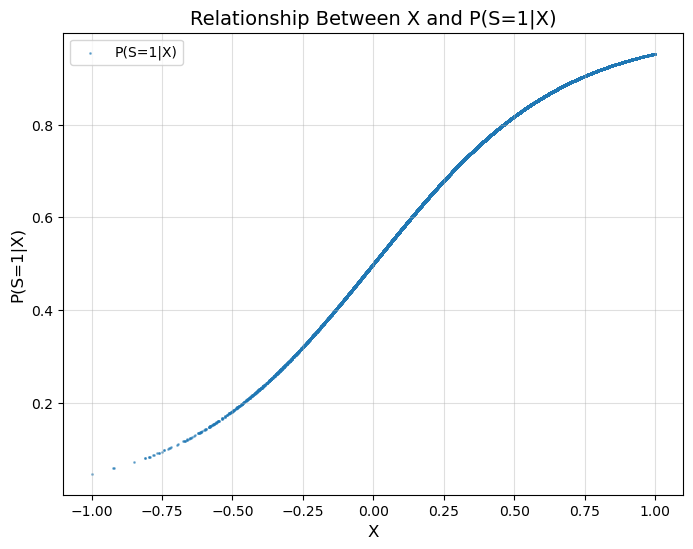

In [ ]:
# Create the plot for P(S=1|X) in MC data
plt.figure(figsize=(8, 6))
plt.scatter(df_mc1["X"], df_mc1["P(S=1|X)"], alpha=0.5, s=1, label="P(S=1|X)")
plt.xlabel("X", fontsize=12)
plt.ylabel("P(S=1|X)", fontsize=12)
plt.title("Relationship Between X and P(S=1|X)", fontsize=14)
plt.grid(True, alpha=0.4)
plt.legend()
plt.show()

In [ ]:
# Compute means and variances of X in each dataset (Figure 2 in the report)
datasets = {
    "Random Trial": df_trial,
    "Adaptive Trial 1-by-1": df_trial_adap1,
    "Adaptive Trial Batch": df_trial_adap2,
    "Adaptive Trial Block": df_trial_adap3,
    "Target Set": df_target,
}


# Dictionary to store the results
results = {"Dataset": [], "Mean_X": [], "Variance_X": []}

# Loop through each dataset and calculate mean and variance
for name, df in datasets.items():
    mean_x = df["X"].mean()
    var_x = df["X"].var()
    results["Dataset"].append(name)
    results["Mean_X"].append(mean_x)
    results["Variance_X"].append(var_x)

# Convert the results dictionary into a DataFrame
df_results = pd.DataFrame(results)

# Display the resulting DataFrame
df_results


,Dataset,Mean_X,Variance_X
0,Random Trial,0.577492,0.064262
1,Adaptive Trial 1-by-1,0.560333,0.067667
2,Adaptive Trial Batch,0.501221,0.080872
3,Adaptive Trial Block,0.471245,0.084073
4,Target Set,0.311569,0.108127


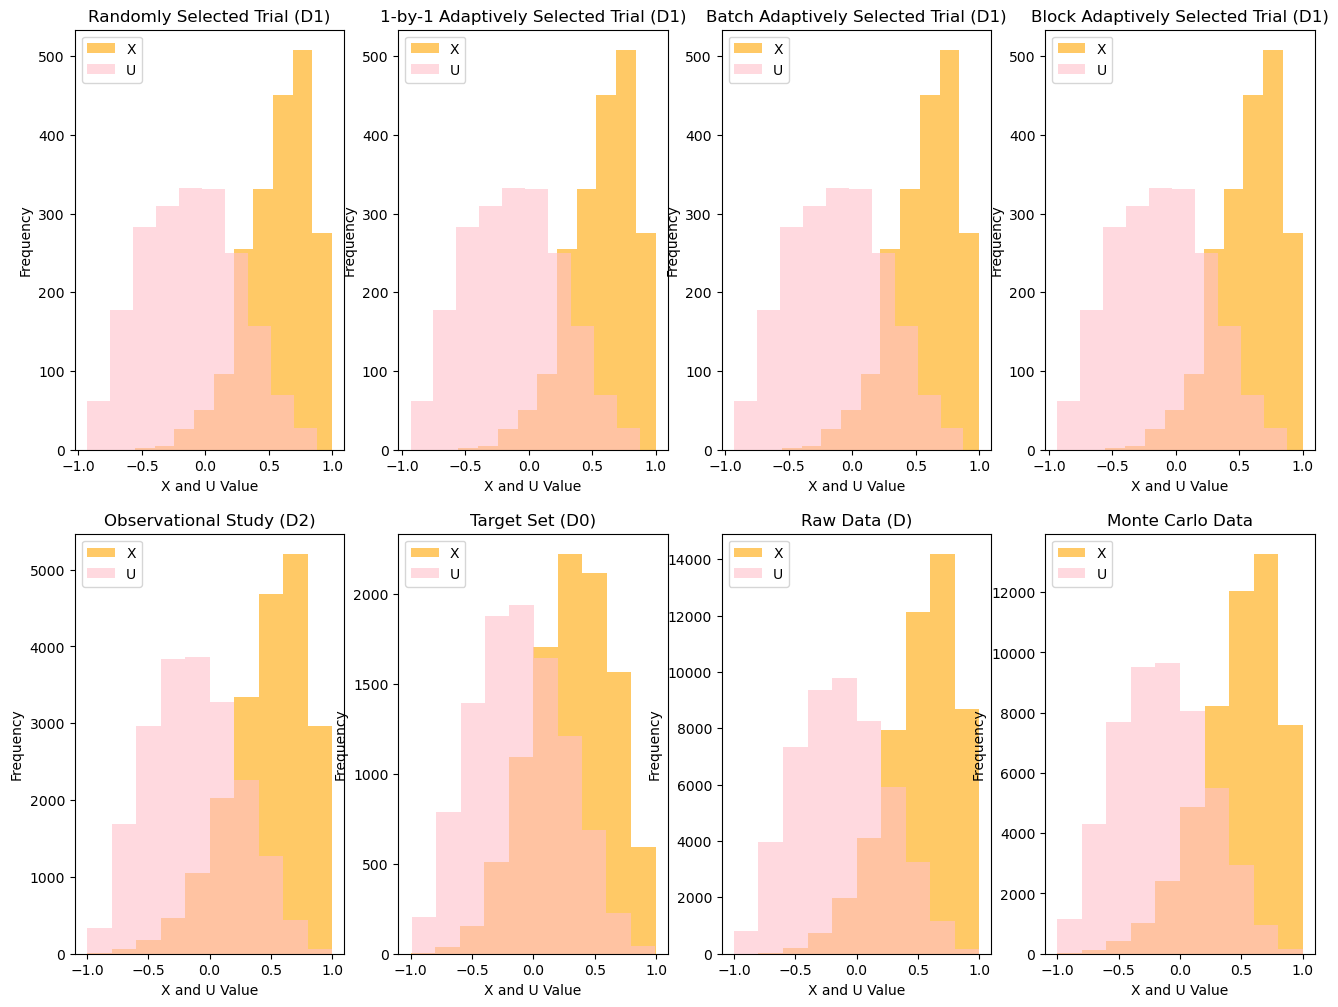

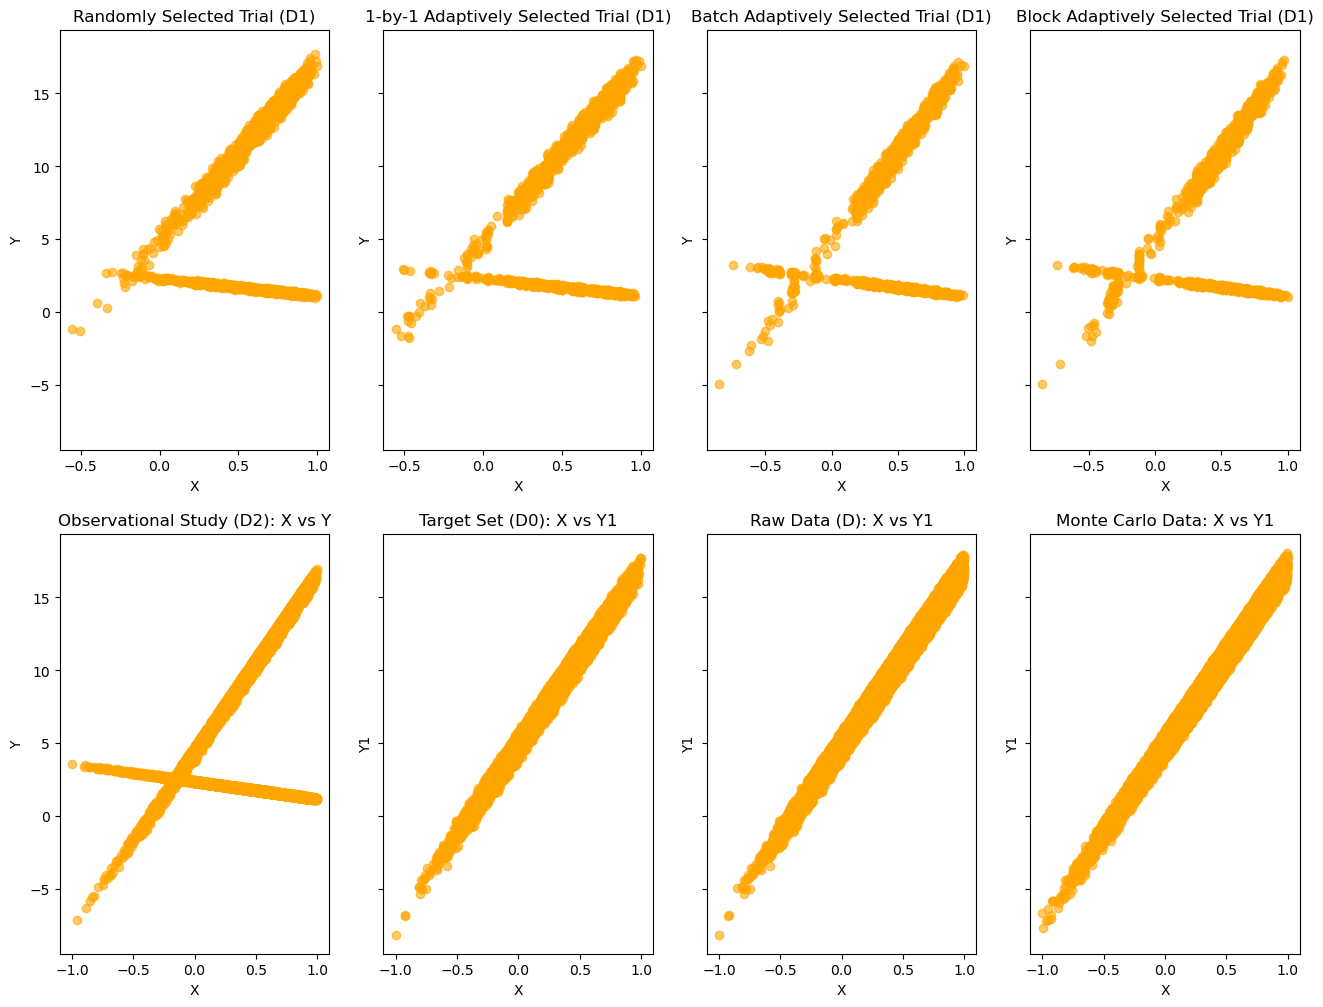

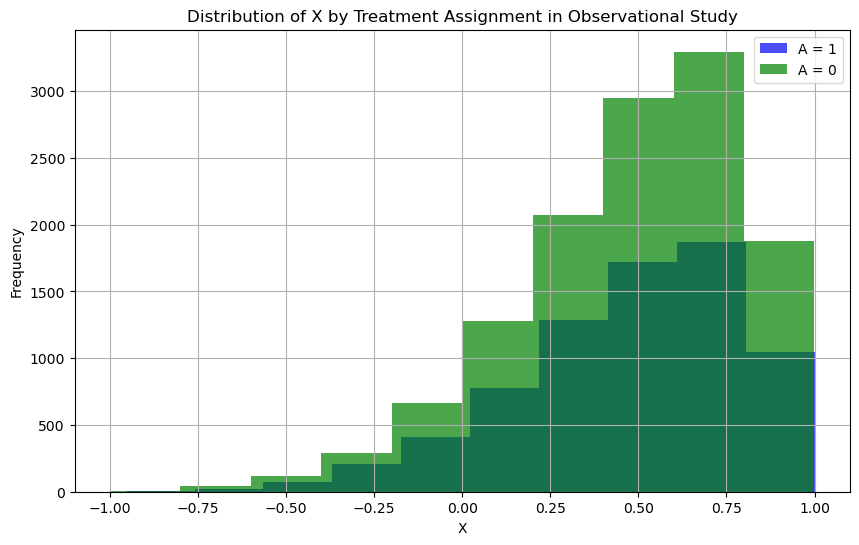

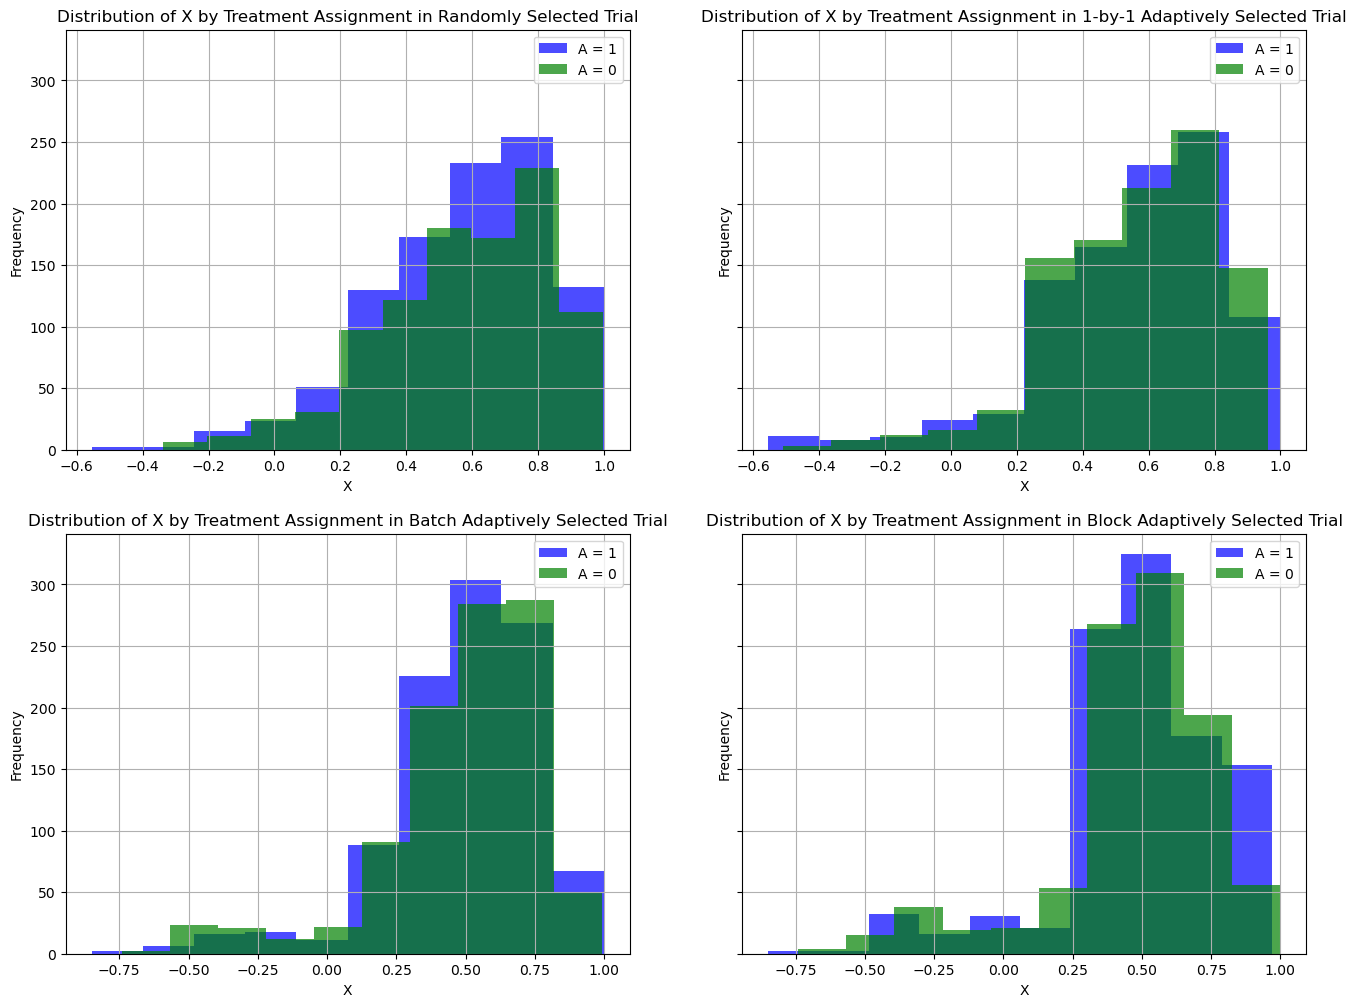

In [ ]:
# Plot 0.1: generated data plots (Figure 1 - 5 in report)
# Hist for X and U distribution
# Create a 2x4 grid layout
fig, axes = plt.subplots(2, 4, figsize=(16, 12), sharey=False)
axes[0,0].hist(df_trial["X"], bins=10, alpha=0.6, label= "X", color="orange")
axes[0,0].hist(df_trial["U"], bins=10, alpha=0.6, label= "U", color="pink")
axes[0,0].set_xlabel("X and U Value")
axes[0,0].set_ylabel("Frequency")
axes[0,0].set_title("Randomly Selected Trial (D1)")
axes[0,0].legend()
axes[0,1].hist(df_trial["X"], bins=10, alpha=0.6, label= "X", color="orange")
axes[0,1].hist(df_trial["U"], bins=10, alpha=0.6, label= "U", color="pink")
axes[0,1].set_xlabel("X and U Value")
axes[0,1].set_ylabel("Frequency")
axes[0,1].set_title("1-by-1 Adaptively Selected Trial (D1)")
axes[0,1].legend()
axes[0,2].hist(df_trial["X"], bins=10, alpha=0.6, label= "X", color="orange")
axes[0,2].hist(df_trial["U"], bins=10, alpha=0.6, label= "U", color="pink")
axes[0,2].set_xlabel("X and U Value")
axes[0,2].set_ylabel("Frequency")
axes[0,2].set_title("Batch Adaptively Selected Trial (D1)")
axes[0,2].legend()
axes[0,3].hist(df_trial["X"], bins=10, alpha=0.6, label= "X", color="orange")
axes[0,3].hist(df_trial["U"], bins=10, alpha=0.6, label= "U", color="pink")
axes[0,3].set_xlabel("X and U Value")
axes[0,3].set_ylabel("Frequency")
axes[0,3].set_title("Block Adaptively Selected Trial (D1)")
axes[0,3].legend()
axes[1,0].hist(df_obs["X"], bins=10, alpha=0.6, label= "X", color="orange")
axes[1,0].hist(df_obs["U"], bins=10, alpha=0.6, label= "U", color="pink")
axes[1,0].set_xlabel("X and U Value")
axes[1,0].set_ylabel("Frequency")
axes[1,0].set_title("Observational Study (D2)")
axes[1,0].legend()
axes[1,1].hist(df_target["X"], bins=10, alpha=0.6, label= "X", color="orange")
axes[1,1].hist(df_target["U"], bins=10, alpha=0.6, label= "U", color="pink")
axes[1,1].set_xlabel("X and U Value")
axes[1,1].set_ylabel("Frequency")
axes[1,1].set_title("Target Set (D0)")
axes[1,1].legend()
axes[1,2].hist(df_mc1["X"], bins=10, alpha=0.6, label= "X", color="orange")
axes[1,2].hist(df_mc1["U"], bins=10, alpha=0.6, label= "U", color="pink")
axes[1,2].set_xlabel("X and U Value")
axes[1,2].set_ylabel("Frequency")
axes[1,2].set_title("Raw Data (D)")
axes[1,2].legend()
axes[1,3].hist(df_mc2["X"], bins=10, alpha=0.6, label= "X", color="orange")
axes[1,3].hist(df_mc2["U"], bins=10, alpha=0.6, label= "U", color="pink")
axes[1,3].set_xlabel("X and U Value")
axes[1,3].set_ylabel("Frequency")
axes[1,3].set_title("Monte Carlo Data")
axes[1,3].legend()
plt.show()


# Scatter plot: X vs Y 
# Create a 2x4 grid layout
fig, axes = plt.subplots(2, 4, figsize=(16, 12), sharey=True)
axes[0,0].scatter(df_trial["X"], df_trial["Y"], alpha=0.6, color="orange")
axes[0,0].set_xlabel("X")
axes[0,0].set_ylabel("Y")
axes[0,0].set_title("Randomly Selected Trial (D1)")
axes[0,1].scatter(df_trial_adap1["X"], df_trial_adap1["Y"], alpha=0.6, color="orange")
axes[0,1].set_xlabel("X")
axes[0,1].set_ylabel("Y")
axes[0,1].set_title("1-by-1 Adaptively Selected Trial (D1)")
axes[0,2].scatter(df_trial_adap2["X"], df_trial_adap2["Y"], alpha=0.6, color="orange")
axes[0,2].set_xlabel("X")
axes[0,2].set_ylabel("Y")
axes[0,2].set_title("Batch Adaptively Selected Trial (D1)")
axes[0,3].scatter(df_trial_adap3["X"], df_trial_adap3["Y"], alpha=0.6, color="orange")
axes[0,3].set_xlabel("X")
axes[0,3].set_ylabel("Y")
axes[0,3].set_title("Block Adaptively Selected Trial (D1)")
axes[1,0].scatter(df_obs["X"], df_obs["Y"], alpha=0.6, color="orange")
axes[1,0].set_xlabel("X")
axes[1,0].set_ylabel("Y")
axes[1,0].set_title("Observational Study (D2): X vs Y")
axes[1,1].scatter(df_target["X"], df_target["Y1"], alpha=0.6, color="orange")
axes[1,1].set_xlabel("X")
axes[1,1].set_ylabel("Y1")
axes[1,1].set_title("Target Set (D0): X vs Y1")
axes[1,2].scatter(df_mc1["X"], df_mc1["Y1"], alpha=0.6, color="orange")
axes[1,2].set_xlabel("X")
axes[1,2].set_ylabel("Y1")
axes[1,2].set_title("Raw Data (D): X vs Y1")
axes[1,3].scatter(df_mc2["X"], df_mc2["Y1"], alpha=0.6, color="orange")
axes[1,3].set_xlabel("X")
axes[1,3].set_ylabel("Y1")
axes[1,3].set_title("Monte Carlo Data: X vs Y1")
plt.show()

# Treatment assignment A vs X
# Filter the trial data by treatment assignment
df_obs_A1 = df_obs[df_obs["A"] == 1]
df_obs_A0 = df_obs[df_obs["A"] == 0]
df_trial_A1 = df_trial[df_trial["A"] == 1]
df_trial_A0 = df_trial[df_trial["A"] == 0]
df_trial_adap1_A1 = df_trial_adap1[df_trial_adap1["A"] == 1]
df_trial_adap1_A0 = df_trial_adap1[df_trial_adap1["A"] == 0]
df_trial_adap2_A1 = df_trial_adap2[df_trial_adap2["A"] == 1]
df_trial_adap2_A0 = df_trial_adap2[df_trial_adap2["A"] == 0]
df_trial_adap3_A1 = df_trial_adap3[df_trial_adap3["A"] == 1]
df_trial_adap3_A0 = df_trial_adap3[df_trial_adap3["A"] == 0]
# Plot for OS
plt.figure(figsize=(10, 6))
plt.hist(df_obs_A1["X"], bins=10, alpha=0.7, label="A = 1", color="blue")
plt.hist(df_obs_A0["X"], bins=10, alpha=0.7, label="A = 0", color="green")
plt.xlabel("X")
plt.ylabel("Frequency")
plt.title("Distribution of X by Treatment Assignment in Observational Study")
plt.legend()
plt.grid(True)
plt.show()
# Plot for trial
# Create a 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
axes[0,0].hist(df_trial_A1["X"], bins=10, alpha=0.7, label="A = 1", color="blue")
axes[0,0].hist(df_trial_A0["X"], bins=10, alpha=0.7, label="A = 0", color="green")
axes[0,0].set_xlabel("X")
axes[0,0].set_ylabel("Frequency")
axes[0,0].set_title("Distribution of X by Treatment Assignment in Randomly Selected Trial")
axes[0,0].legend()
axes[0,0].grid(True)
axes[0,1].hist(df_trial_adap1_A1["X"], bins=10, alpha=0.7, label="A = 1", color="blue")
axes[0,1].hist(df_trial_adap1_A0["X"], bins=10, alpha=0.7, label="A = 0", color="green")
axes[0,1].set_xlabel("X")
axes[0,1].set_ylabel("Frequency")
axes[0,1].set_title("Distribution of X by Treatment Assignment in 1-by-1 Adaptively Selected Trial")
axes[0,1].legend()
axes[0,1].grid(True)
axes[1,0].hist(df_trial_adap2_A1["X"], bins=10, alpha=0.7, label="A = 1", color="blue")
axes[1,0].hist(df_trial_adap2_A0["X"], bins=10, alpha=0.7, label="A = 0", color="green")
axes[1,0].set_xlabel("X")
axes[1,0].set_ylabel("Frequency")
axes[1,0].set_title("Distribution of X by Treatment Assignment in Batch Adaptively Selected Trial")
axes[1,0].legend()
axes[1,0].grid(True)
axes[1,1].hist(df_trial_adap3_A1["X"], bins=10, alpha=0.7, label="A = 1", color="blue")
axes[1,1].hist(df_trial_adap3_A0["X"], bins=10, alpha=0.7, label="A = 0", color="green")
axes[1,1].set_xlabel("X")
axes[1,1].set_ylabel("Frequency")
axes[1,1].set_title("Distribution of X by Treatment Assignment in Block Adaptively Selected Trial")
axes[1,1].legend()
axes[1,1].grid(True)
plt.show()


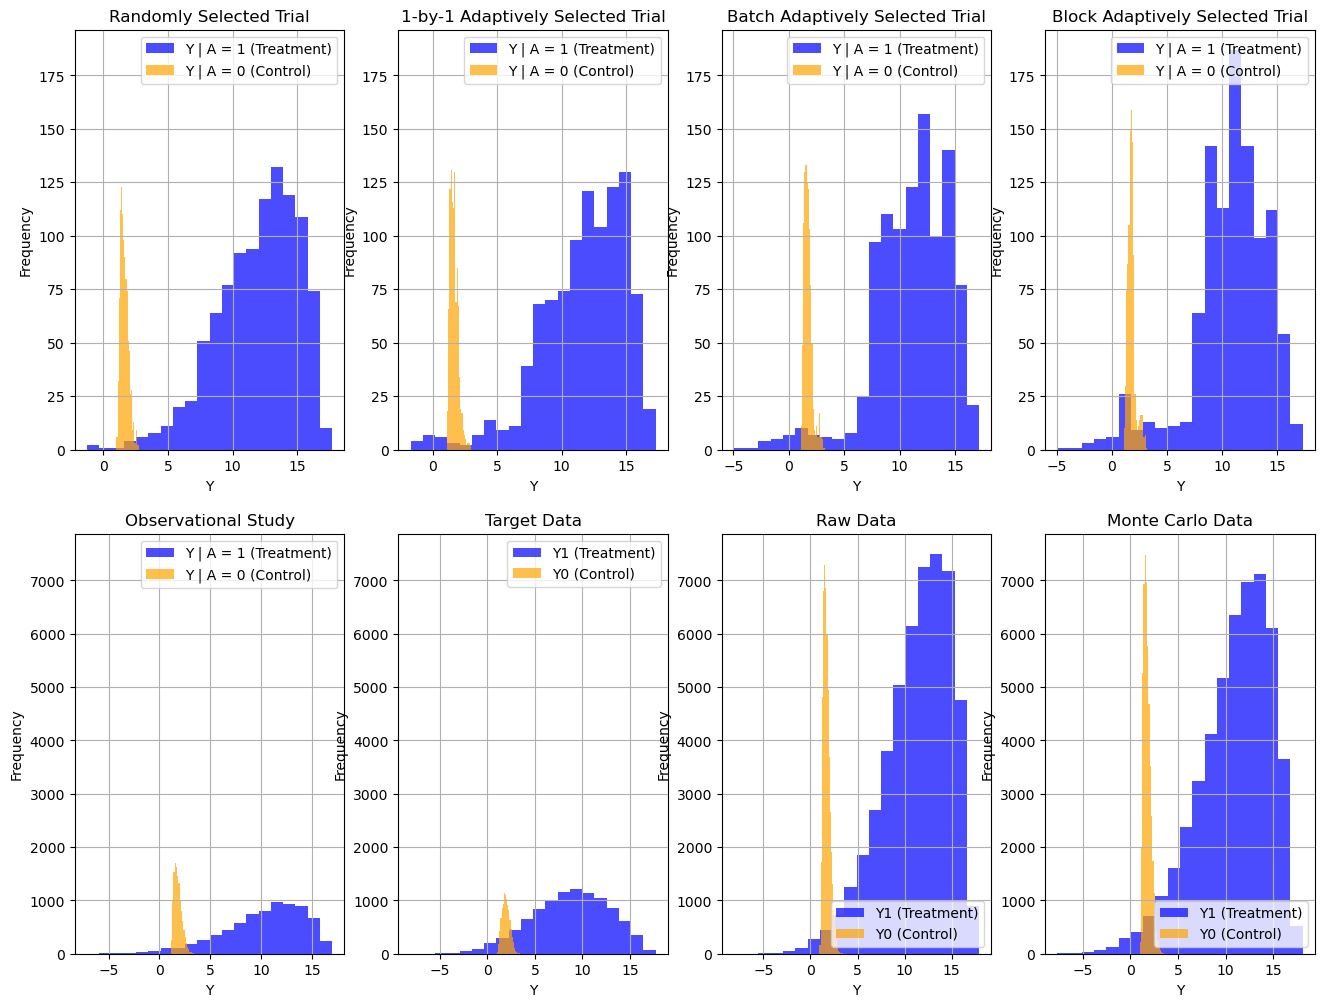

In [ ]:
# Plot 0.2 for A vs Y (Figure 6 in report)
# Filter Y based on A
trial_y_a1 = df_trial[df_trial["A"] == 1]
trial_y_a0 = df_trial[df_trial["A"] == 0]
trial_adap1_y_a1 = df_trial_adap1[df_trial_adap1["A"] == 1]
trial_adap1_y_a0 = df_trial_adap1[df_trial_adap1["A"] == 0]
trial_adap2_y_a1 = df_trial_adap2[df_trial_adap2["A"] == 1]
trial_adap2_y_a0 = df_trial_adap2[df_trial_adap2["A"] == 0]
trial_adap3_y_a1 = df_trial_adap3[df_trial_adap3["A"] == 1]
trial_adap3_y_a0 = df_trial_adap3[df_trial_adap3["A"] == 0]
obs_y_a1 = df_obs[df_obs["A"] == 1]
obs_y_a0 = df_obs[df_obs["A"] == 0]

fig, axes = plt.subplots(2, 4, figsize=(16, 12))
# First row: Share y-axis across all columns in the first row
for i in range(1, 4):
    axes[0, i].sharey(axes[0, 0])
# Second row: Share y-axis across all columns in the second row
for i in range(1, 4):
    axes[1, i].sharey(axes[1, 0])
axes[0,0].hist(trial_y_a1["Y"], bins=20, alpha=0.7, label='Y | A = 1 (Treatment)', color='blue')
axes[0,0].hist(trial_y_a0["Y"], bins=20, alpha=0.7, label='Y | A = 0 (Control)', color='orange')
axes[0,0].set_xlabel('Y')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Randomly Selected Trial')
axes[0,0].legend(loc="upper right")
axes[0,0].grid(True)
axes[0,1].hist(trial_adap1_y_a1["Y"], bins=20, alpha=0.7, label='Y | A = 1 (Treatment)', color='blue')
axes[0,1].hist(trial_adap1_y_a0["Y"], bins=20, alpha=0.7, label='Y | A = 0 (Control)', color='orange')
axes[0,1].set_xlabel('Y')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('1-by-1 Adaptively Selected Trial')
axes[0,1].legend(loc="upper right")
axes[0,1].grid(True)
axes[0,2].hist(trial_adap2_y_a1["Y"], bins=20, alpha=0.7, label='Y | A = 1 (Treatment)', color='blue')
axes[0,2].hist(trial_adap2_y_a0["Y"], bins=20, alpha=0.7, label='Y | A = 0 (Control)', color='orange')
axes[0,2].set_xlabel('Y')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Batch Adaptively Selected Trial')
axes[0,2].legend(loc="upper right")
axes[0,2].grid(True)
axes[0,3].hist(trial_adap3_y_a1["Y"], bins=20, alpha=0.7, label='Y | A = 1 (Treatment)', color='blue')
axes[0,3].hist(trial_adap3_y_a0["Y"], bins=20, alpha=0.7, label='Y | A = 0 (Control)', color='orange')
axes[0,3].set_xlabel('Y')
axes[0,3].set_ylabel('Frequency')
axes[0,3].set_title('Block Adaptively Selected Trial')
axes[0,3].legend(loc="upper right")
axes[0,3].grid(True)

axes[1,0].hist(obs_y_a1["Y"], bins=20, alpha=0.7, label='Y | A = 1 (Treatment)', color='blue')
axes[1,0].hist(obs_y_a0["Y"], bins=20, alpha=0.7, label='Y | A = 0 (Control)', color='orange')
axes[1,0].set_xlabel('Y')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Observational Study')
axes[1,0].grid(True)
axes[1,0].legend(loc="upper right")
axes[1,1].hist(df_target["Y1"], bins=20, alpha=0.7, label='Y1 (Treatment)', color='blue')
axes[1,1].hist(df_target["Y0"], bins=20, alpha=0.7, label='Y0 (Control)', color='orange')
axes[1,1].set_xlabel('Y')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Target Data')
axes[1,1].legend(loc="upper right")
axes[1,1].grid(True)
axes[1,2].hist(df_mc1["Y1"], bins=20, alpha=0.7, label='Y1 (Treatment)', color='blue')
axes[1,2].hist(df_mc1["Y0"], bins=20, alpha=0.7, label='Y0 (Control)', color='orange')
axes[1,2].set_xlabel('Y')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_title('Raw Data')
axes[1,2].legend(loc="lower right")
axes[1,2].grid(True)
axes[1,3].hist(df_mc2["Y1"], bins=20, alpha=0.7, label='Y1 (Treatment)', color='blue')
axes[1,3].hist(df_mc2["Y0"], bins=20, alpha=0.7, label='Y0 (Control)', color='orange')
axes[1,3].set_xlabel('Y')
axes[1,3].set_ylabel('Frequency')
axes[1,3].set_title('Monte Carlo Data')
axes[1,3].legend(loc="lower right")
axes[1,3].grid(True)
plt.show()


In [797]:
# Main Execution: Change the random_seed to get slighly different results 

# Set Parameters
n_raw = 50000 # number of raw data 
n_rct_start = 200 # number of data in trial 
n_rct_end = 1000 
step = 100
n_tar = 10000 # number of data in target distribution 
n_obs = 20000  # number of observational data 
random_seed = 68
#random_seed = 42
#random_seed = 88

#############################################
n_rct = np.arange(n_rct_start, n_rct_end, step)  
n_rct = np.append(n_rct, n_rct_end)  

# Initialize result DataFrames
mean_result_df = pd.DataFrame(index=range(len(n_rct)), columns=["Number of trial", "Baseline 1", "Baseline 2", "ABC", "AOM"])
std_result_df = pd.DataFrame(index=range(len(n_rct)), columns=["Number of trial", "Baseline 1", "Baseline 2", "ABC", "AOM"])

mean_result_df_adap1 = mean_result_df.copy()
std_result_df_adap1 = std_result_df.copy()
mean_result_df_adap2 = mean_result_df.copy()
std_result_df_adap2 = std_result_df.copy()
mean_result_df_adap3 = mean_result_df.copy()
std_result_df_adap3 = std_result_df.copy()

true_mean_result_df = pd.DataFrame(index=range(len(n_rct)), columns=["Number of trial", "MC1_S0", "MC2_S0", "Target_S0"])
true_std_result_df = pd.DataFrame(index=range(len(n_rct)), columns=["Number of trial", "MC1_S0", "MC2_S0", "Target_S0"])

mean_mse_df = pd.DataFrame(index=range(len(n_rct)), columns=[
    "Number of trial", "MC1 vs Baseline 1", "MC1 vs Baseline 2", "MC1 vs ABC", "MC1 vs AOM",
    "MC2 vs Baseline 1", "MC2 vs Baseline 2", "MC2 vs ABC", "MC2 vs AOM",
    "Target vs Baseline 1", "Target vs Baseline 2", "Target vs ABC", "Target vs AOM"
])
mean_mse_df_adap1 = mean_mse_df.copy()
mean_mse_df_adap2 = mean_mse_df.copy()
mean_mse_df_adap3 = mean_mse_df.copy()

# Assign trial numbers
mean_result_df["Number of trial"] = n_rct
std_result_df["Number of trial"] = n_rct
mean_result_df_adap1["Number of trial"] = n_rct
std_result_df_adap1["Number of trial"] = n_rct
mean_result_df_adap2["Number of trial"] = n_rct
std_result_df_adap2["Number of trial"] = n_rct
mean_result_df_adap3["Number of trial"] = n_rct
std_result_df_adap3["Number of trial"] = n_rct
true_mean_result_df["Number of trial"] = n_rct
true_std_result_df["Number of trial"] = n_rct
mean_mse_df["Number of trial"] = n_rct
mean_mse_df_adap1["Number of trial"] = n_rct
mean_mse_df_adap2["Number of trial"] = n_rct
mean_mse_df_adap3["Number of trial"] = n_rct

# Main loop for data generation and result computation
for i in range(len(n_rct)):
    print(i)
    # Generate data
    df_trial, df_trial_adap1, df_trial_adap2, df_trial_adap3, df_target, df_obs, df_mc1, df_mc2, data_stats, mc_stats = generate_data(n_raw, n_rct[i], n_tar, n_obs, random_seed)
    result_stats_randomTrial = estimate(df_trial, df_target, df_obs)
    result_stats_adaptiveTrial1 = estimate(df_trial_adap1, df_target, df_obs)
    result_stats_adaptiveTrial2 = estimate(df_trial_adap2, df_target, df_obs)
    result_stats_adaptiveTrial3 = estimate(df_trial_adap3, df_target, df_obs)

    # Populate true mean and std results
    true_mean_result_df.loc[i, "MC1_S0"] = mc_stats.loc[mc_stats["Type"] == "MC1_S0", "Mean"].values[0]
    true_mean_result_df.loc[i, "MC2_S0"] = mc_stats.loc[mc_stats["Type"] == "MC2_S0", "Mean"].values[0]
    true_mean_result_df.loc[i, "Target_S0"] = data_stats.loc[data_stats["Type"] == "Target Outcome", "Mean"].values[0]
    true_std_result_df.loc[i, "MC1_S0"] = mc_stats.loc[mc_stats["Type"] == "MC1_S0", "Std"].values[0]
    true_std_result_df.loc[i, "MC2_S0"] = mc_stats.loc[mc_stats["Type"] == "MC2_S0", "Std"].values[0]
    true_std_result_df.loc[i, "Target_S0"] = data_stats.loc[data_stats["Type"] == "Target Outcome", "Std"].values[0]

    # Populate mean and std results for random trials
    mean_result_df.loc[i, ["Baseline 1", "Baseline 2", "ABC", "AOM"]] = result_stats_randomTrial["Mean"].values
    std_result_df.loc[i, ["Baseline 1", "Baseline 2", "ABC", "AOM"]] = result_stats_randomTrial["Std"].values

    # Populate mean and std results for adaptive trials
    mean_result_df_adap1.loc[i, ["Baseline 1", "Baseline 2", "ABC", "AOM"]] = result_stats_adaptiveTrial1["Mean"].values
    std_result_df_adap1.loc[i, ["Baseline 1", "Baseline 2", "ABC", "AOM"]] = result_stats_adaptiveTrial1["Std"].values

    mean_result_df_adap2.loc[i, ["Baseline 1", "Baseline 2", "ABC", "AOM"]] = result_stats_adaptiveTrial2["Mean"].values
    std_result_df_adap2.loc[i, ["Baseline 1", "Baseline 2", "ABC", "AOM"]] = result_stats_adaptiveTrial2["Std"].values

    mean_result_df_adap3.loc[i, ["Baseline 1", "Baseline 2", "ABC", "AOM"]] = result_stats_adaptiveTrial3["Mean"].values
    std_result_df_adap3.loc[i, ["Baseline 1", "Baseline 2", "ABC", "AOM"]] = result_stats_adaptiveTrial3["Std"].values

    # Populate MSE results for random trials
    for method in ["Baseline 1", "Baseline 2", "ABC", "AOM"]:
        for target in ["MC1_S0", "MC2_S0", "Target_S0"]:
            mse_col = f"{target.split('_')[0]} vs {method}"
            mean_mse_df.loc[i, mse_col] = (mean_result_df.loc[i, method] - true_mean_result_df.loc[i, target]) ** 2

    # Populate MSE results for adaptive trials
    for df_adap, mse_df in zip(
        [mean_result_df_adap1, mean_result_df_adap2, mean_result_df_adap3],
        [mean_mse_df_adap1, mean_mse_df_adap2, mean_mse_df_adap3]
    ):
        for method in ["Baseline 1", "Baseline 2", "ABC", "AOM"]:
            for target in ["MC1_S0", "MC2_S0", "Target_S0"]:
                mse_col = f"{target.split('_')[0]} vs {method}"
                mse_df.loc[i, mse_col] = (df_adap.loc[i, method] - true_mean_result_df.loc[i, target]) ** 2


0
1
2
3
4
5
6
7
8


In [798]:
print(mean_mse_df)
print(mean_mse_df_adap1)
print(mean_mse_df_adap2)
print(mean_mse_df_adap3)

   Number of trial MC1 vs Baseline 1 MC1 vs Baseline 2 MC1 vs ABC MC1 vs AOM  \
0              200         16.966589          9.931631   9.241085    8.91292   
1              300         16.966589          9.581125   8.900704    8.64368   
2              400         16.966589          8.975279   7.969028   7.742917   
3              500         16.966589          8.272821   7.427858   7.073374   
4              600         16.966589          8.608071   7.951415   7.473196   
5              700         16.966589          8.482127   7.828519   7.551512   
6              800         16.966589          8.747008   8.014408   7.722587   
7              900         16.966589          9.055954   8.147332   7.973908   
8             1000         16.966589          9.350005   8.644356   8.503037   

  MC2 vs Baseline 1 MC2 vs Baseline 2 MC2 vs ABC MC2 vs AOM  \
0          51.53396         38.577923  37.204865  36.543418   
1          51.53396         37.884063  36.518679   35.99613   
2         

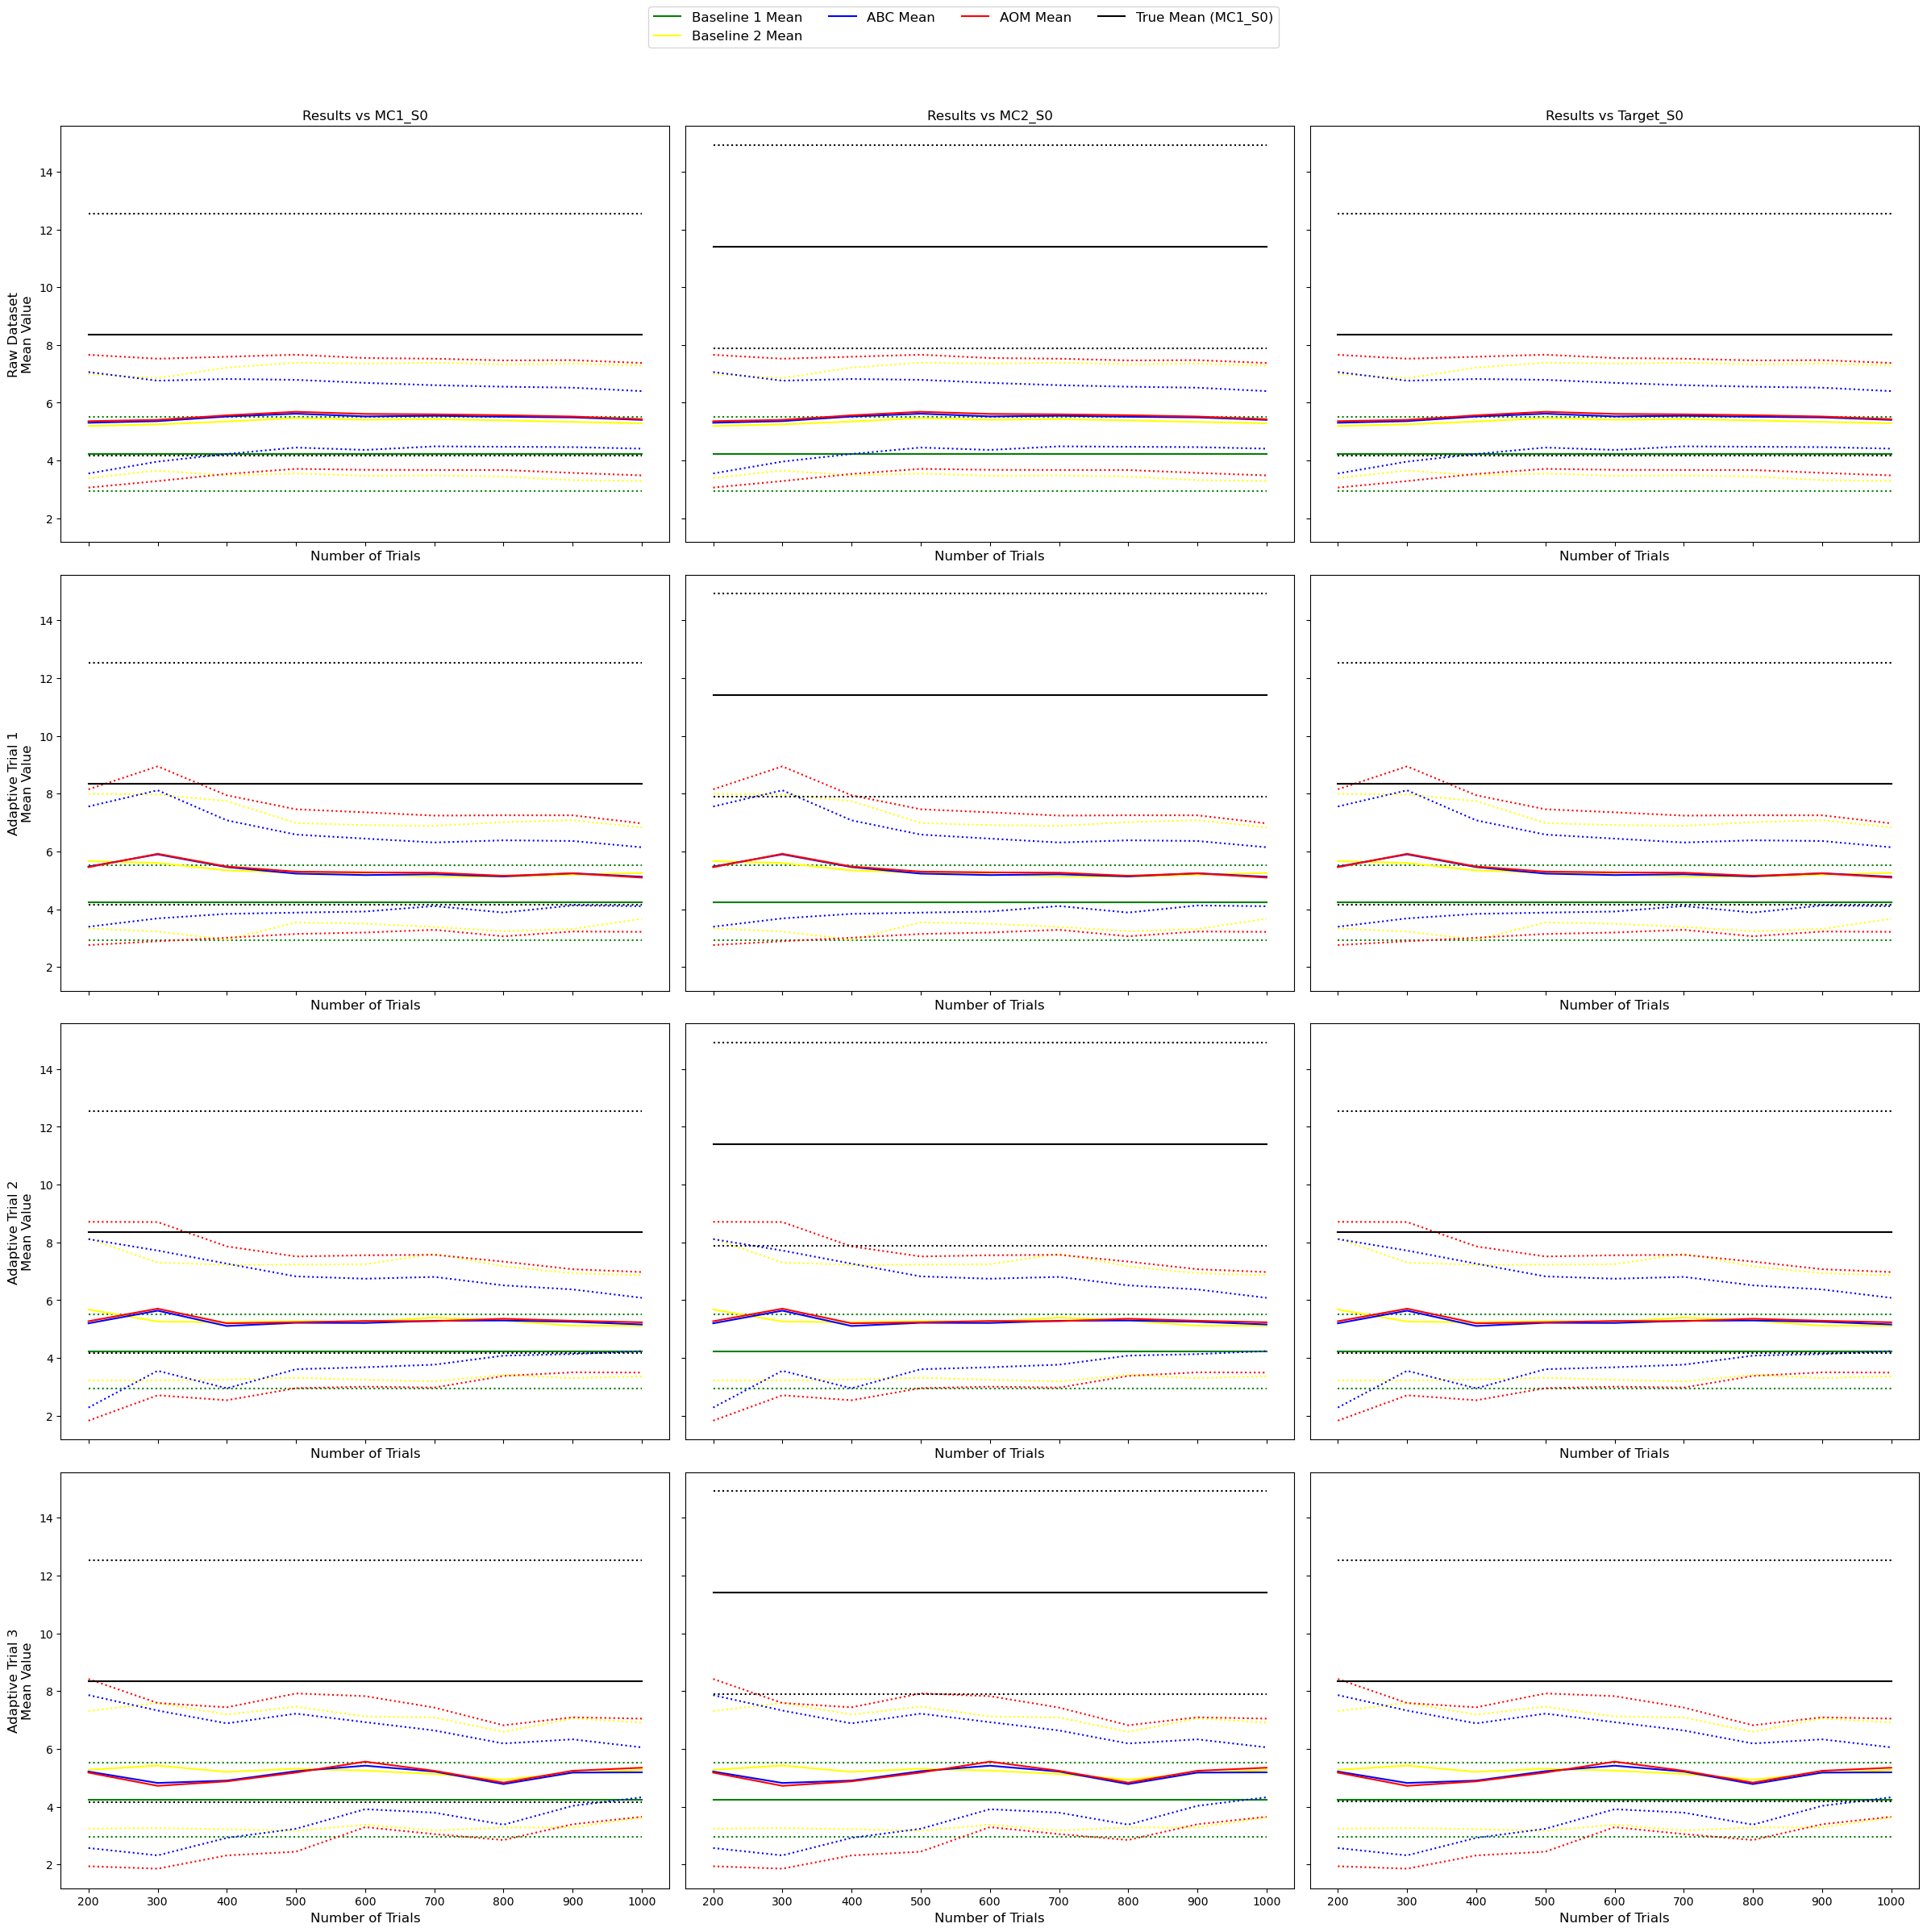

In [ ]:
# Plot 1.1: 4x3 the mean and std comparison between methods and the true value (Figure 7 in report)
# Define the datasets and true mean columns for plotting
datasets = [
    (mean_result_df, std_result_df, true_mean_result_df, true_std_result_df),
    (mean_result_df_adap1, std_result_df_adap1, true_mean_result_df, true_std_result_df),
    (mean_result_df_adap2, std_result_df_adap2, true_mean_result_df, true_std_result_df),
    (mean_result_df_adap3, std_result_df_adap3, true_mean_result_df, true_std_result_df)
]
titles = ["Raw Dataset", "Adaptive Trial 1", "Adaptive Trial 2", "Adaptive Trial 3"]
true_targets = ["MC1_S0", "MC2_S0", "Target_S0"]

# Create the figure and axes for the 4x3 grid
fig, axes = plt.subplots(4, 3, figsize=(24, 24), sharex=True, sharey=True)

# Define methods and colors
methods = ["Baseline 1", "Baseline 2", "ABC", "AOM"]
colors = ["green", "yellow", "blue", "red"]

# Loop over rows (datasets) and columns (true targets)
for row_idx, (dataset, title) in enumerate(zip(datasets, titles)):
    mean_df, std_df, true_mean_df, true_std_df = dataset
    x_values = mean_df["Number of trial"].to_numpy(dtype=np.int64)
    
    for col_idx, target in enumerate(true_targets):
        ax = axes[row_idx, col_idx]
        
        # Plot mean and ± std dev for each method
        for method, color in zip(methods, colors):
            mean_values = mean_df[method].astype(float)
            std_values = std_df[method].astype(float)
            ax.plot(x_values, mean_values, label=f"{method} Mean", color=color)
            ax.plot(x_values, mean_values + std_values, linestyle=':', color=color, label="_nolegend_")
            ax.plot(x_values, mean_values - std_values, linestyle=':', color=color, label="_nolegend_")
        
        # Plot true mean and ± std dev for the current target
        true_mean_values = true_mean_df[target].astype(float)
        true_std_values = true_std_df[target].astype(float)
        ax.plot(x_values, true_mean_values, label=f"True Mean ({target})", color='black')
        ax.plot(x_values, true_mean_values + true_std_values, linestyle=':', color='black', label="_nolegend_")
        ax.plot(x_values, true_mean_values - true_std_values, linestyle=':', color='black', label="_nolegend_")
        
        # Add title and labels
        if row_idx == 0:
            ax.set_title(f"Results vs {target}", fontsize=12)
        if col_idx == 0:
            ax.set_ylabel(f"{title}\nMean Value", fontsize=12)
        ax.set_xlabel("Number of Trials", fontsize=12)

# Adjust layout and add a legend for the first row
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=12)

# Tighten layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plot
plt.show()



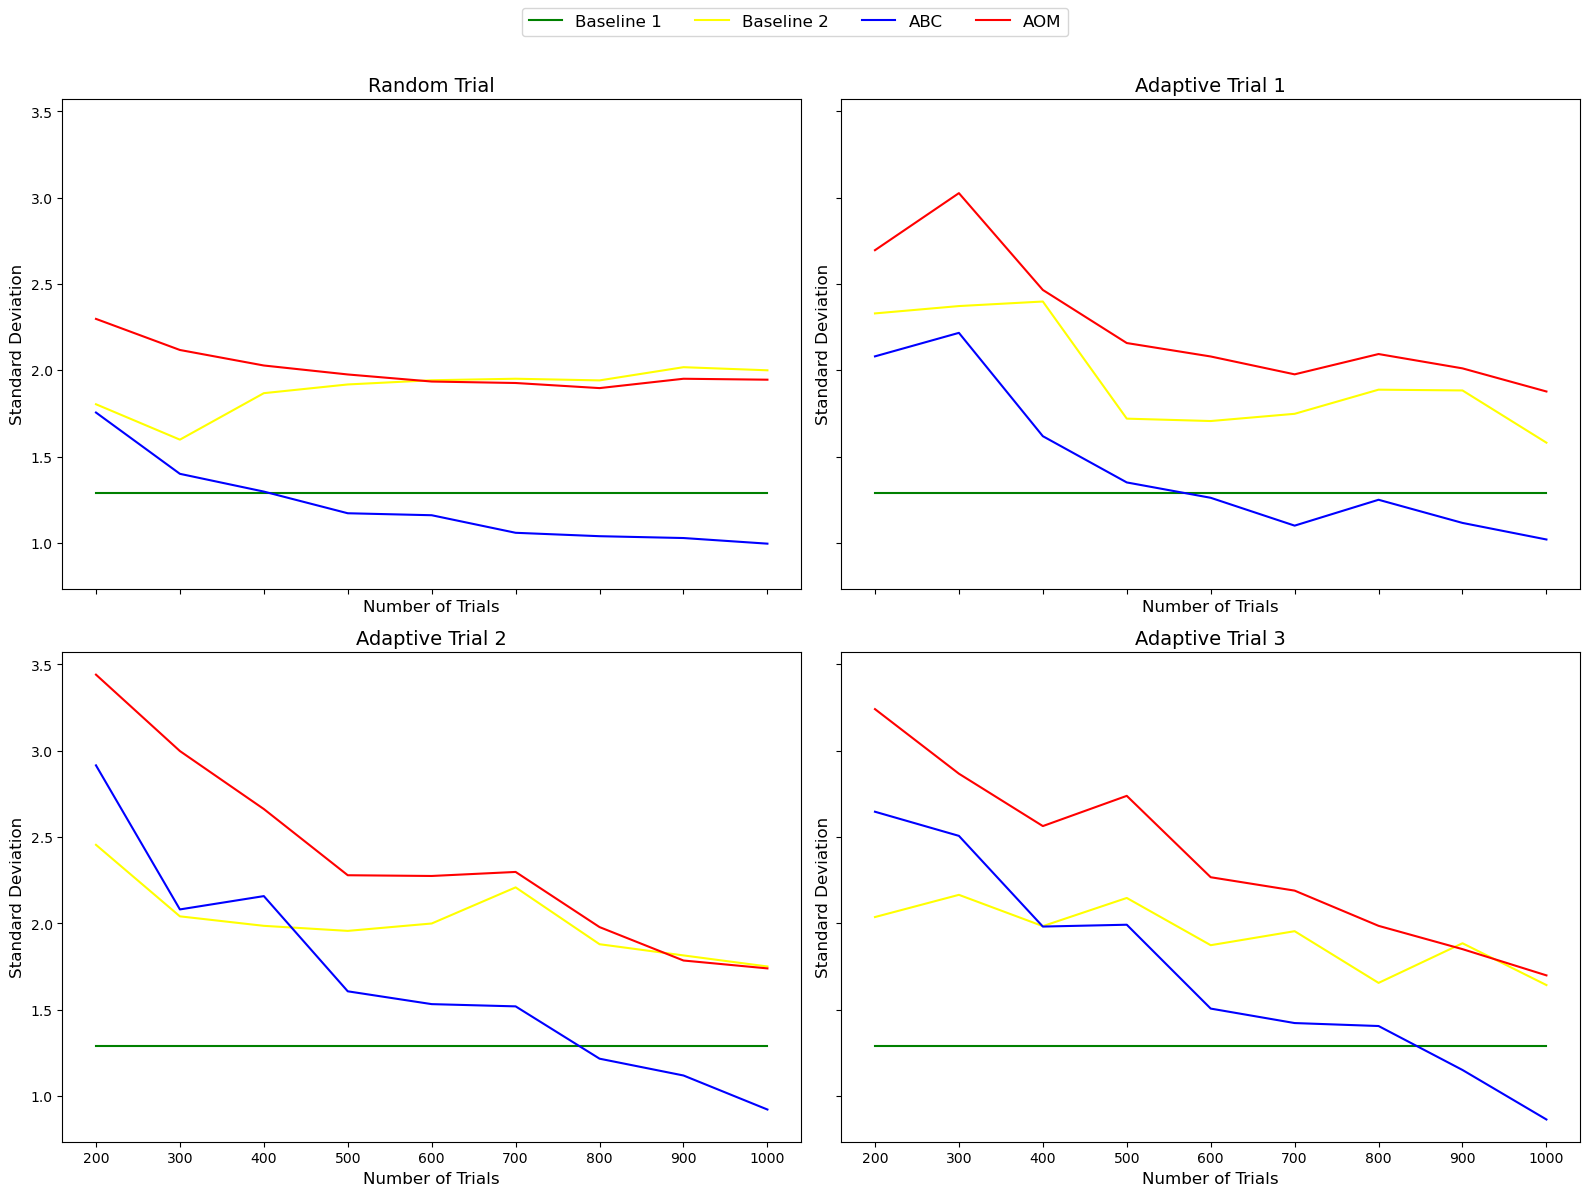

In [ ]:
# Plot 1.2: 4x3 the std comparison between methods (Figure 8 in report)

# Define the datasets and titles
datasets = [
    (std_result_df, "Random Trial"),
    (std_result_df_adap1, "Adaptive Trial 1"),
    (std_result_df_adap2, "Adaptive Trial 2"),
    (std_result_df_adap3, "Adaptive Trial 3")
]

# Create the figure and axes for the 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)

# Define methods and colors
methods = ["Baseline 1", "Baseline 2", "ABC", "AOM"]
colors = ["green", "yellow", "blue", "red"]

# Loop over the datasets and corresponding axes
for ax, (std_df, title) in zip(axes.ravel(), datasets):
    x_values = std_df["Number of trial"].to_numpy(dtype=np.int64)
    
    # Plot std for each method
    for method, color in zip(methods, colors):
        std_values = std_df[method].astype(float)
        ax.plot(x_values, std_values, linestyle='-', color=color, label=method)
    
    # Add title and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Number of Trials", fontsize=12)
    ax.set_ylabel("Standard Deviation", fontsize=12)

# Add a single legend for all subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=12)

# Tighten layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




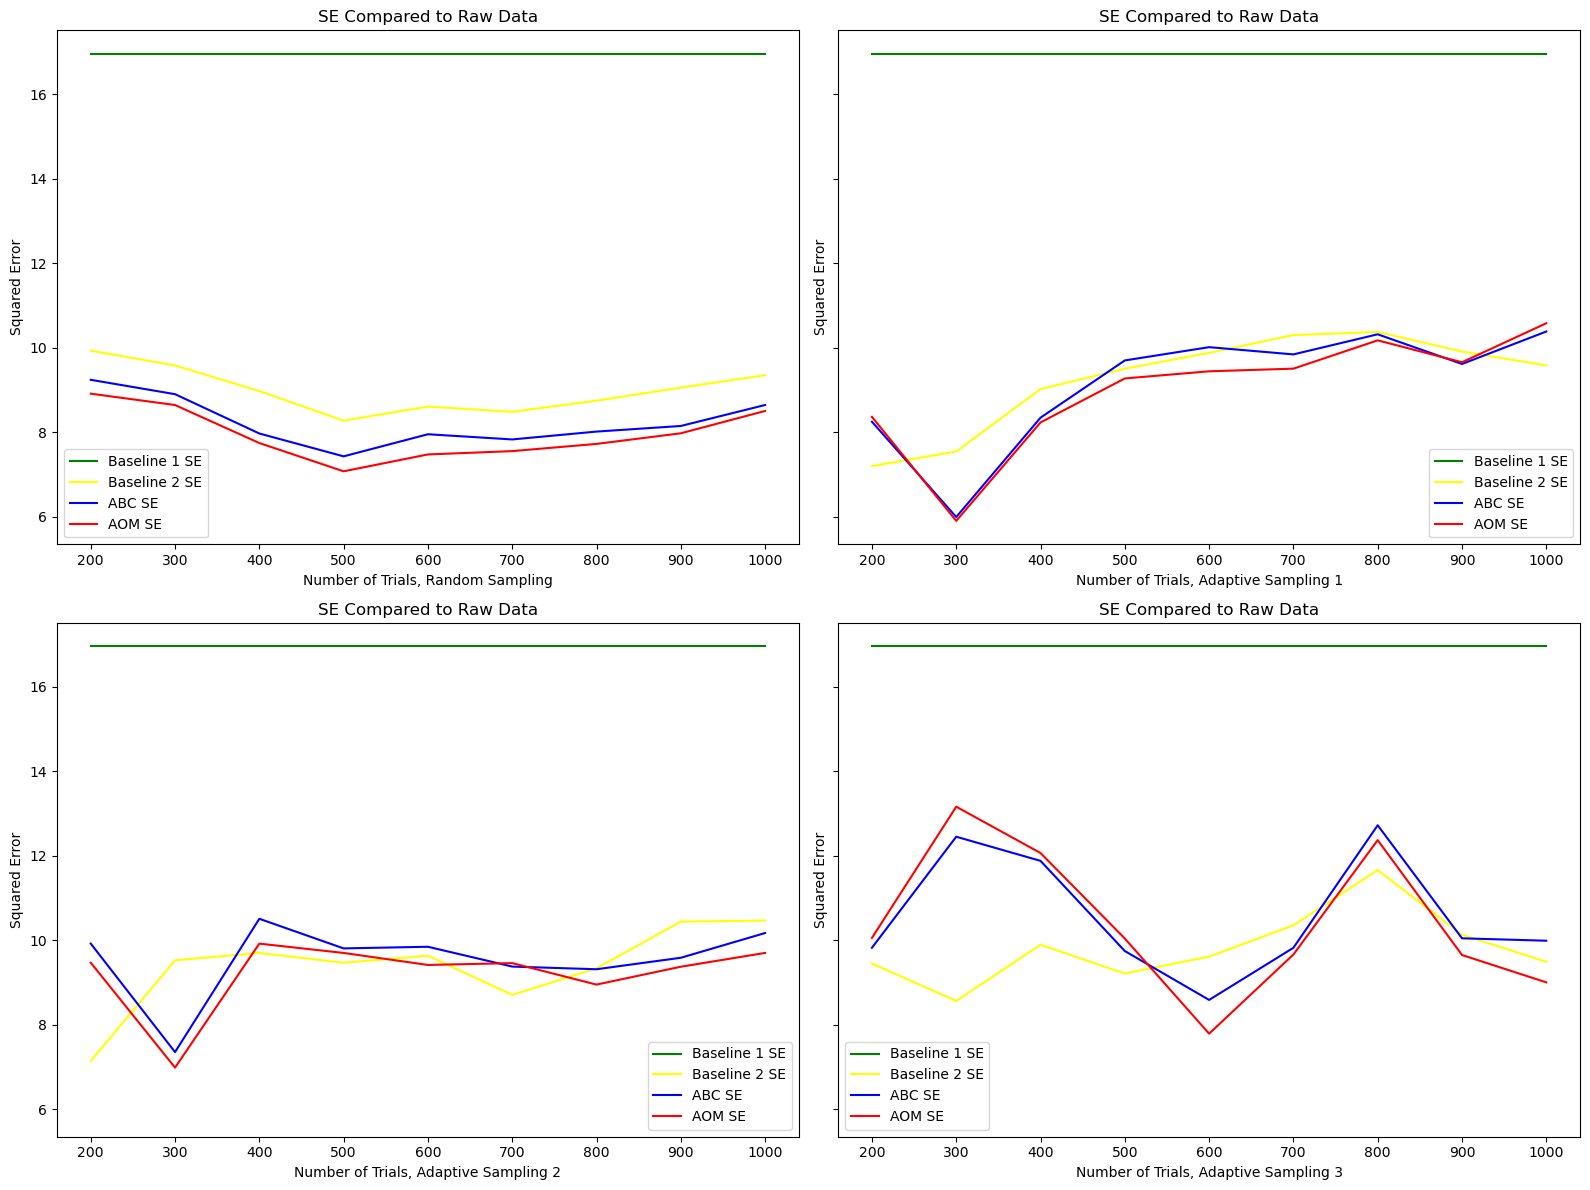

In [ ]:
# Plot 2.1 plots the SE comparison between 4 methods, standard result = Raw Data (Figure 9 in report)

# Extract x-values
x_values_random = mean_mse_df["Number of trial"].to_numpy(dtype=np.int64)
x_values_adap1 = mean_mse_df_adap1["Number of trial"].to_numpy(dtype=np.int64)
x_values_adap2 = mean_mse_df_adap2["Number of trial"].to_numpy(dtype=np.int64)
x_values_adap3 = mean_mse_df_adap3["Number of trial"].to_numpy(dtype=np.int64)

# Define methods and colors
methods = ["Baseline 1", "Baseline 2", "ABC", "AOM"]
colors = ["green", "yellow", "blue", "red"]

# Create a 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)

# Adjust y-axis range for all plots
#y_min, y_max = 0, 0.5  # Adjust as needed
#for ax in axes.flatten():
#    ax.set_ylim(y_min, y_max)

# Plot: Random Sampling
for method, color in zip(methods, colors):
    mse_values = mean_mse_df[f"MC1 vs {method}"].astype(float)
    axes[0, 0].plot(x_values_random, mse_values, label=f"{method} SE", color=color, linestyle="-")

axes[0, 0].set_xlabel("Number of Trials, Random Sampling")
axes[0, 0].set_ylabel("Squared Error")
axes[0, 0].set_title("SE Compared to Raw Data")
axes[0, 0].legend()

# Plot: Adaptive Sampling 1
for method, color in zip(methods, colors):
    mse_values_adap1 = mean_mse_df_adap1[f"MC1 vs {method}"].astype(float)
    axes[0, 1].plot(x_values_adap1, mse_values_adap1, label=f"{method} SE", color=color, linestyle="-")

axes[0, 1].set_xlabel("Number of Trials, Adaptive Sampling 1")
axes[0, 1].set_ylabel("Squared Error")
axes[0, 1].set_title("SE Compared to Raw Data")
axes[0, 1].legend()

# Plot: Adaptive Sampling 2
for method, color in zip(methods, colors):
    mse_values_adap2 = mean_mse_df_adap2[f"MC1 vs {method}"].astype(float)
    axes[1, 0].plot(x_values_adap2, mse_values_adap2, label=f"{method} SE", color=color, linestyle="-")

axes[1, 0].set_xlabel("Number of Trials, Adaptive Sampling 2")
axes[1, 0].set_ylabel("Squared Error")
axes[1, 0].set_title("SE Compared to Raw Data")
axes[1, 0].legend()

# Plot: Adaptive Sampling 3
for method, color in zip(methods, colors):
    mse_values_adap3 = mean_mse_df_adap3[f"MC1 vs {method}"].astype(float)
    axes[1, 1].plot(x_values_adap3, mse_values_adap3, label=f"{method} SE", color=color, linestyle="-")

axes[1, 1].set_xlabel("Number of Trials, Adaptive Sampling 3")
axes[1, 1].set_ylabel("Squared Error")
axes[1, 1].set_title("SE Compared to Raw Data")
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
# Display the combined plot
plt.show()




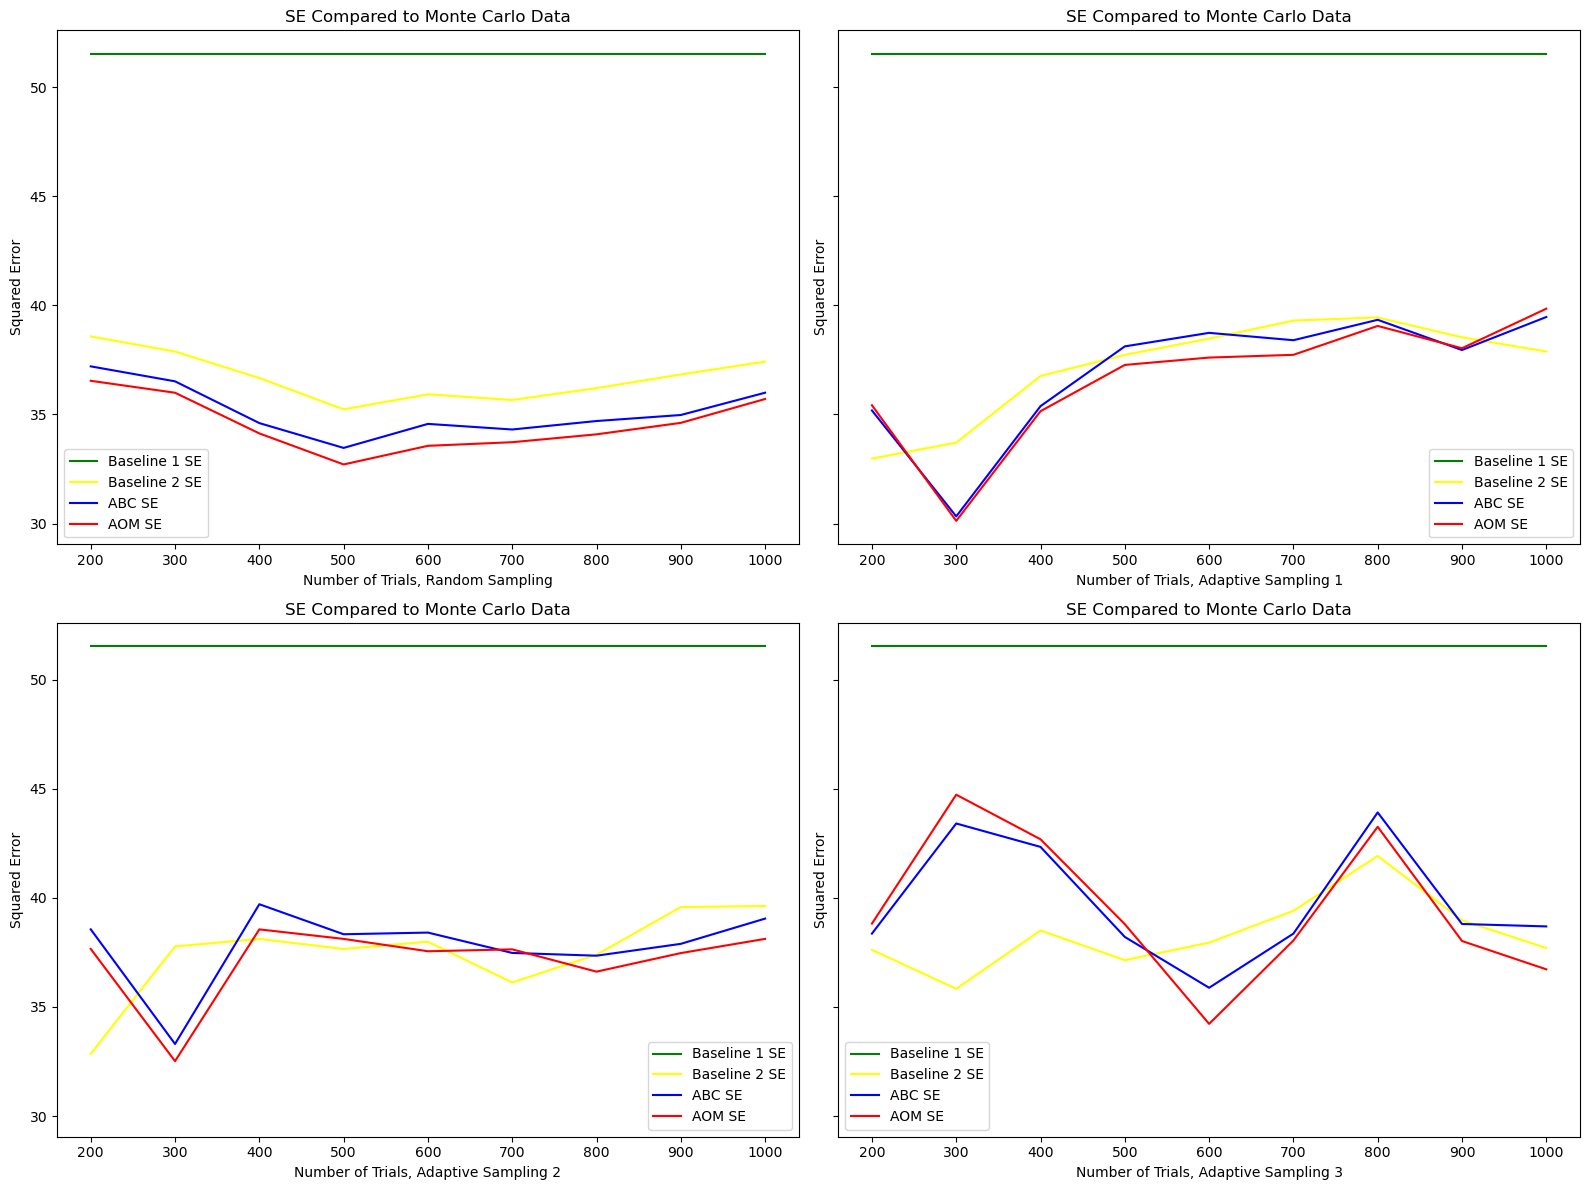

In [ ]:
# Plot 2.2 plots the SE comparison between 4 methods, standard result = Monte Carlo Data (Figure 10 in report)

# Extract x-values
x_values_random = mean_mse_df["Number of trial"].to_numpy(dtype=np.int64)
x_values_adap1 = mean_mse_df_adap1["Number of trial"].to_numpy(dtype=np.int64)
x_values_adap2 = mean_mse_df_adap2["Number of trial"].to_numpy(dtype=np.int64)
x_values_adap3 = mean_mse_df_adap3["Number of trial"].to_numpy(dtype=np.int64)

# Define methods and colors
methods = ["Baseline 1", "Baseline 2", "ABC", "AOM"]
colors = ["green", "yellow", "blue", "red"]

# Create a 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)

# Adjust y-axis range for all plots
#y_min, y_max = 0, 0.5  # Adjust as needed
#for ax in axes.flatten():
#    ax.set_ylim(y_min, y_max)

# Plot: Random Sampling
for method, color in zip(methods, colors):
    mse_values = mean_mse_df[f"MC2 vs {method}"].astype(float)
    axes[0, 0].plot(x_values_random, mse_values, label=f"{method} SE", color=color, linestyle="-")

axes[0, 0].set_xlabel("Number of Trials, Random Sampling")
axes[0, 0].set_ylabel("Squared Error")
axes[0, 0].set_title("SE Compared to Monte Carlo Data")
axes[0, 0].legend()

# Plot: Adaptive Sampling 1
for method, color in zip(methods, colors):
    mse_values_adap1 = mean_mse_df_adap1[f"MC2 vs {method}"].astype(float)
    axes[0, 1].plot(x_values_adap1, mse_values_adap1, label=f"{method} SE", color=color, linestyle="-")

axes[0, 1].set_xlabel("Number of Trials, Adaptive Sampling 1")
axes[0, 1].set_ylabel("Squared Error")
axes[0, 1].set_title("SE Compared to Monte Carlo Data")
axes[0, 1].legend()

# Plot: Adaptive Sampling 2
for method, color in zip(methods, colors):
    mse_values_adap2 = mean_mse_df_adap2[f"MC2 vs {method}"].astype(float)
    axes[1, 0].plot(x_values_adap2, mse_values_adap2, label=f"{method} SE", color=color, linestyle="-")

axes[1, 0].set_xlabel("Number of Trials, Adaptive Sampling 2")
axes[1, 0].set_ylabel("Squared Error")
axes[1, 0].set_title("SE Compared to Monte Carlo Data")
axes[1, 0].legend()

# Plot: Adaptive Sampling 3
for method, color in zip(methods, colors):
    mse_values_adap3 = mean_mse_df_adap3[f"MC2 vs {method}"].astype(float)
    axes[1, 1].plot(x_values_adap3, mse_values_adap3, label=f"{method} SE", color=color, linestyle="-")

axes[1, 1].set_xlabel("Number of Trials, Adaptive Sampling 3")
axes[1, 1].set_ylabel("Squared Error")
axes[1, 1].set_title("SE Compared to Monte Carlo Data")
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
# Display the combined plot
plt.show()





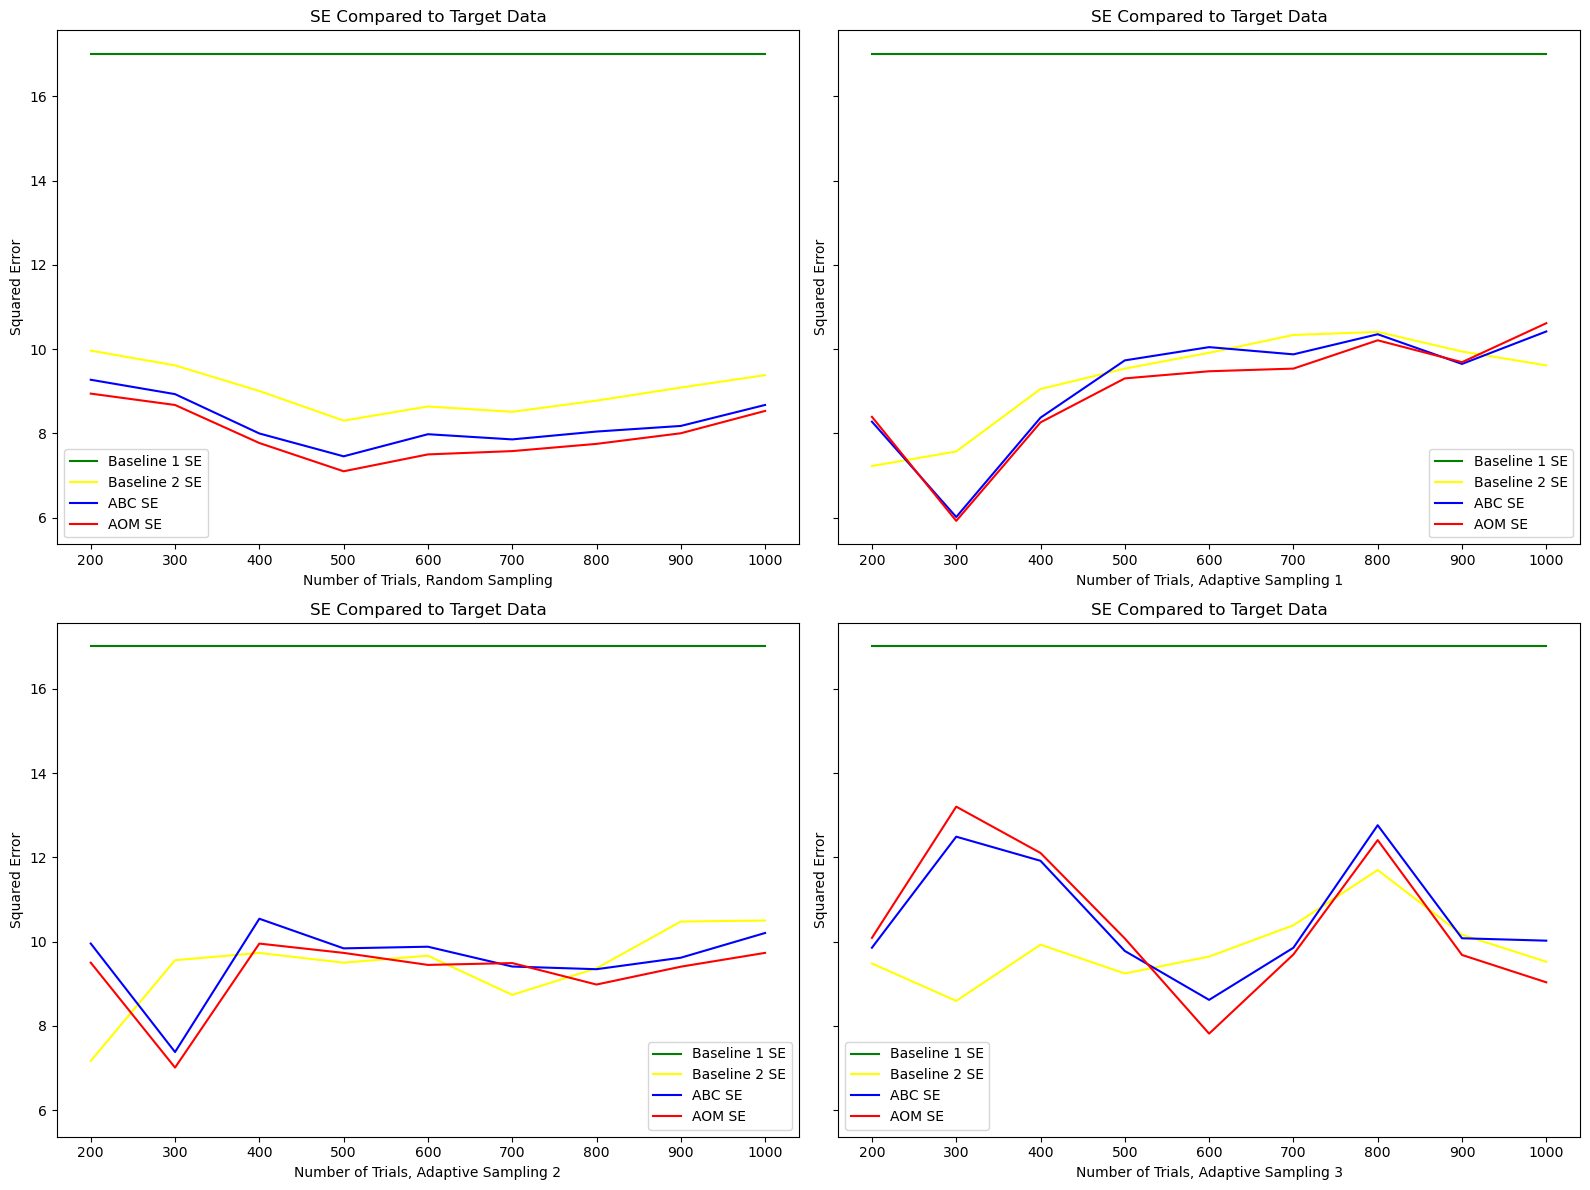

In [ ]:
# Plot 2.3 plots the SE comparison between 4 methods, standard result = Target Data (Figure 11 in report)

# Extract x-values
x_values_random = mean_mse_df["Number of trial"].to_numpy(dtype=np.int64)
x_values_adap1 = mean_mse_df_adap1["Number of trial"].to_numpy(dtype=np.int64)
x_values_adap2 = mean_mse_df_adap2["Number of trial"].to_numpy(dtype=np.int64)
x_values_adap3 = mean_mse_df_adap3["Number of trial"].to_numpy(dtype=np.int64)

# Define methods and colors
methods = ["Baseline 1", "Baseline 2", "ABC", "AOM"]
colors = ["green", "yellow", "blue", "red"]

# Create a 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)

# Adjust y-axis range for all plots
#y_min, y_max = 0, 0.5  # Adjust as needed
#for ax in axes.flatten():
#    ax.set_ylim(y_min, y_max)

# Plot: Random Sampling
for method, color in zip(methods, colors):
    mse_values = mean_mse_df[f"Target vs {method}"].astype(float)
    axes[0, 0].plot(x_values_random, mse_values, label=f"{method} SE", color=color, linestyle="-")

axes[0, 0].set_xlabel("Number of Trials, Random Sampling")
axes[0, 0].set_ylabel("Squared Error")
axes[0, 0].set_title("SE Compared to Target Data")
axes[0, 0].legend()

# Plot: Adaptive Sampling 1
for method, color in zip(methods, colors):
    mse_values_adap1 = mean_mse_df_adap1[f"Target vs {method}"].astype(float)
    axes[0, 1].plot(x_values_adap1, mse_values_adap1, label=f"{method} SE", color=color, linestyle="-")

axes[0, 1].set_xlabel("Number of Trials, Adaptive Sampling 1")
axes[0, 1].set_ylabel("Squared Error")
axes[0, 1].set_title("SE Compared to Target Data")
axes[0, 1].legend()

# Plot: Adaptive Sampling 2
for method, color in zip(methods, colors):
    mse_values_adap2 = mean_mse_df_adap2[f"Target vs {method}"].astype(float)
    axes[1, 0].plot(x_values_adap2, mse_values_adap2, label=f"{method} SE", color=color, linestyle="-")

axes[1, 0].set_xlabel("Number of Trials, Adaptive Sampling 2")
axes[1, 0].set_ylabel("Squared Error")
axes[1, 0].set_title("SE Compared to Target Data")
axes[1, 0].legend()

# Plot: Adaptive Sampling 3
for method, color in zip(methods, colors):
    mse_values_adap3 = mean_mse_df_adap3[f"Target vs {method}"].astype(float)
    axes[1, 1].plot(x_values_adap3, mse_values_adap3, label=f"{method} SE", color=color, linestyle="-")

axes[1, 1].set_xlabel("Number of Trials, Adaptive Sampling 3")
axes[1, 1].set_ylabel("Squared Error")
axes[1, 1].set_title("SE Compared to Target Data")
axes[1, 1].legend()

# Adjust layout
plt.tight_layout()
# Display the combined plot
plt.show()






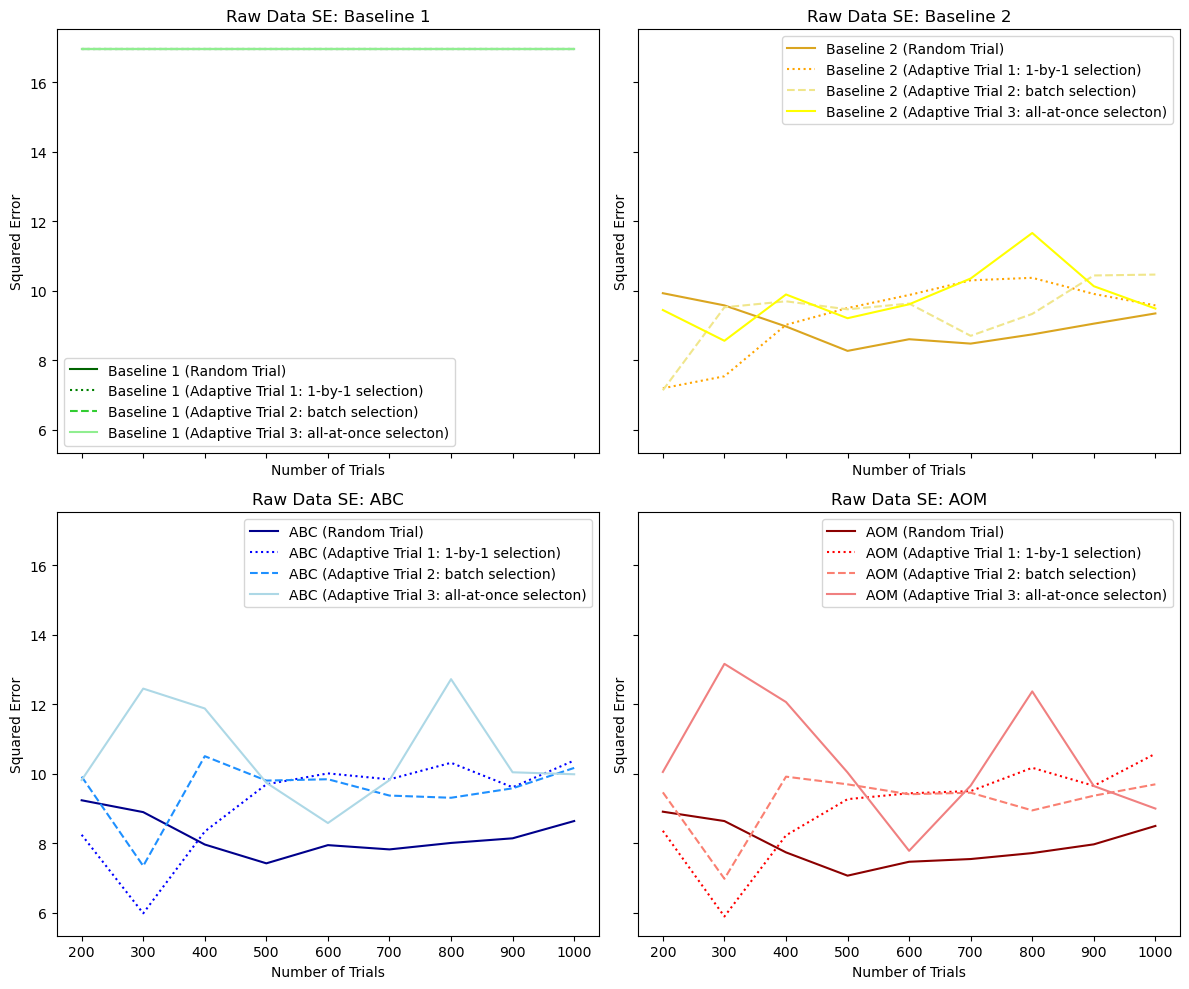

In [ ]:
# Plot 3.1 compares the SE of different methods between random trial and adaptive trial, standard = MC1 (Raw Data) (Figure 12 in report)
# Extract x-values
x_values = mean_mse_df["Number of trial"].to_numpy(dtype=np.int64)

# Define methods and colors
methods = ["Baseline 1", "Baseline 2", "ABC", "AOM"]
colors = [["darkgreen", "green", "limegreen", "lightgreen"], ["goldenrod", "orange", "khaki", "yellow"], ["darkblue", "blue", "dodgerblue", "lightblue"], ["darkred", "red", "salmon", "lightcoral"]]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through each method and corresponding axes
for i, (method, ax) in enumerate(zip(methods, axes)):
    # Plot random trial selection
    ax.plot(
        x_values, 
        mean_mse_df[f"MC1 vs {method}"].astype(float), 
        label=f"{method} (Random Trial)", 
        color=colors[i][0]
    )
    # Plot adaptive trial selections
    ax.plot(
        x_values, 
        mean_mse_df_adap1[f"MC1 vs {method}"].astype(float), 
        label=f"{method} (Adaptive Trial 1: 1-by-1 selection)", 
        color=colors[i][1],
        linestyle=":"
    )
    ax.plot(
        x_values, 
        mean_mse_df_adap2[f"MC1 vs {method}"].astype(float), 
        label=f"{method} (Adaptive Trial 2: batch selection)", 
        color=colors[i][2],
        linestyle="--"
    )
    ax.plot(
        x_values, 
        mean_mse_df_adap3[f"MC1 vs {method}"].astype(float), 
        label=f"{method} (Adaptive Trial 3: all-at-once selecton)", 
        color=colors[i][3]
    )
    ax.set_title(f"Raw Data SE: {method}")
    ax.set_xlabel("Number of Trials")
    ax.set_ylabel("Squared Error")
    ax.legend()

# Adjust layout
plt.tight_layout()

# Display the combined plot
plt.show()


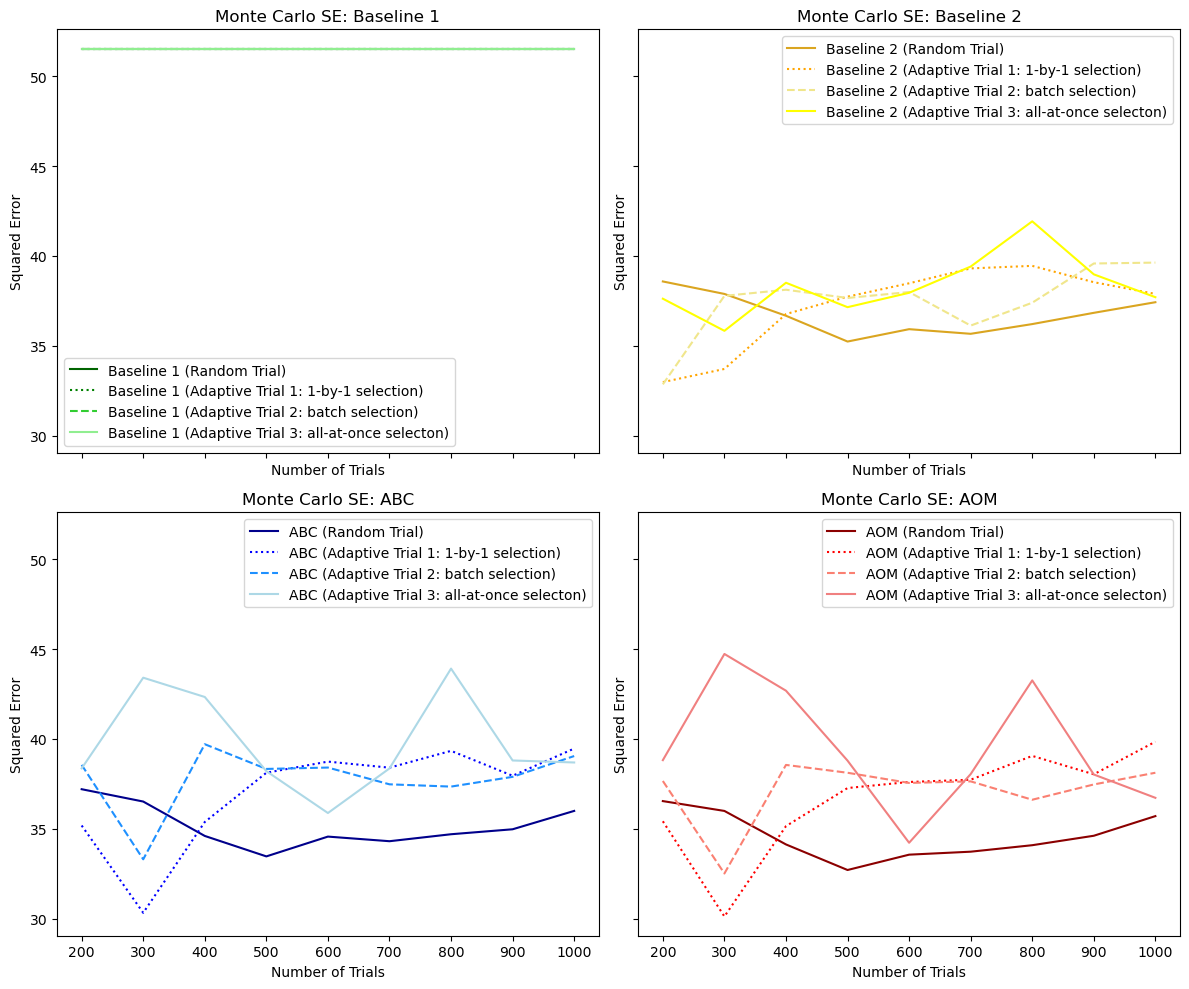

In [ ]:
# Plot 3.2 compares the SE of different methods between random trial and adaptive trial, standard = MC2 (Monte Carlo Data) (Figure 13 in report)

# Extract x-values
x_values = mean_mse_df["Number of trial"].to_numpy(dtype=np.int64)

# Define methods and colors
methods = ["Baseline 1", "Baseline 2", "ABC", "AOM"]
colors = [["darkgreen", "green", "limegreen", "lightgreen"], ["goldenrod", "orange", "khaki", "yellow"], ["darkblue", "blue", "dodgerblue", "lightblue"], ["darkred", "red", "salmon", "lightcoral"]]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through each method and corresponding axes
for i, (method, ax) in enumerate(zip(methods, axes)):
    # Plot random trial selection
    ax.plot(
        x_values, 
        mean_mse_df[f"MC2 vs {method}"].astype(float), 
        label=f"{method} (Random Trial)", 
        color=colors[i][0]
    )
    # Plot adaptive trial selections
    ax.plot(
        x_values, 
        mean_mse_df_adap1[f"MC2 vs {method}"].astype(float), 
        label=f"{method} (Adaptive Trial 1: 1-by-1 selection)", 
        color=colors[i][1],
        linestyle=":"
    )
    ax.plot(
        x_values, 
        mean_mse_df_adap2[f"MC2 vs {method}"].astype(float), 
        label=f"{method} (Adaptive Trial 2: batch selection)", 
        color=colors[i][2],
        linestyle="--"
    )
    ax.plot(
        x_values, 
        mean_mse_df_adap3[f"MC2 vs {method}"].astype(float), 
        label=f"{method} (Adaptive Trial 3: all-at-once selecton)", 
        color=colors[i][3]
    )
    ax.set_title(f"Monte Carlo SE: {method}")
    ax.set_xlabel("Number of Trials")
    ax.set_ylabel("Squared Error")
    ax.legend()

# Adjust layout
plt.tight_layout()

# Display the combined plot
plt.show()



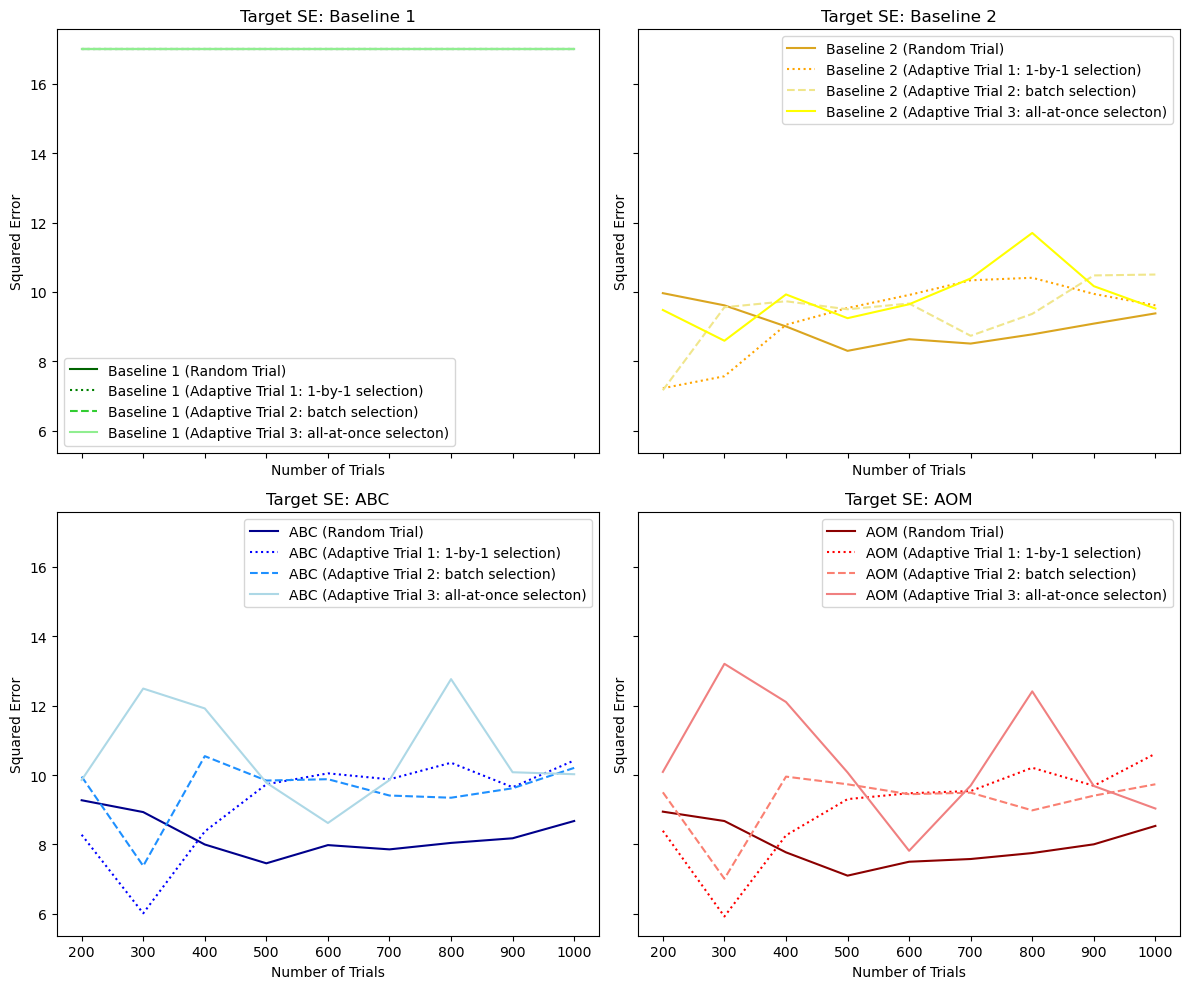

In [ ]:
# Plot 3.3 compares the SE of different methods between random trial and adaptive trial, standard = Target Data (Figure 14 in report)
# Extract x-values
x_values = mean_mse_df["Number of trial"].to_numpy(dtype=np.int64)

# Define methods and colors
methods = ["Baseline 1", "Baseline 2", "ABC", "AOM"]
colors = [["darkgreen", "green", "limegreen", "lightgreen"], ["goldenrod", "orange", "khaki", "yellow"], ["darkblue", "blue", "dodgerblue", "lightblue"], ["darkred", "red", "salmon", "lightcoral"]]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through each method and corresponding axes
for i, (method, ax) in enumerate(zip(methods, axes)):
    # Plot random trial selection
    ax.plot(
        x_values, 
        mean_mse_df[f"Target vs {method}"].astype(float), 
        label=f"{method} (Random Trial)", 
        color=colors[i][0]
    )
    # Plot adaptive trial selections
    ax.plot(
        x_values, 
        mean_mse_df_adap1[f"Target vs {method}"].astype(float), 
        label=f"{method} (Adaptive Trial 1: 1-by-1 selection)", 
        color=colors[i][1],
        linestyle=":"
    )
    ax.plot(
        x_values, 
        mean_mse_df_adap2[f"Target vs {method}"].astype(float), 
        label=f"{method} (Adaptive Trial 2: batch selection)", 
        color=colors[i][2],
        linestyle="--"
    )
    ax.plot(
        x_values, 
        mean_mse_df_adap3[f"Target vs {method}"].astype(float), 
        label=f"{method} (Adaptive Trial 3: all-at-once selecton)", 
        color=colors[i][3]
    )
    ax.set_title(f"Target SE: {method}")
    ax.set_xlabel("Number of Trials")
    ax.set_ylabel("Squared Error")
    ax.legend()

# Adjust layout
plt.tight_layout()

# Display the combined plot
plt.show()


